# Proyecto Final: Prediccion de Dengue en Colombia

curso: Aprendizaje no supervisado

Projecto Final del curso.


In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import colorcet as cc

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from time import time
from sklearn.metrics import silhouette_score

import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

## Cargar los datos

In [173]:
dengue_df = pd.read_csv("../data/dengue_data_all_municipalities.csv")
dengue_df.shape

(1121, 1017)

In [174]:
dengue_df.head(10)

,Municipality code,Municipality,Population2007,Population2008,Population2009,Population2010,Population2011,Population2012,Population2013,Population2014,...,2019/w43,2019/w44,2019/w45,2019/w46,2019/w47,2019/w48,2019/w49,2019/w50,2019/w51,2019/w52
0,5001,Medellín,2286126,2309689,2331389,2353410,2379920,2410046,2428850,2436071,...,29,17,35,16,21,15,20,30,14,5
1,5002,Abejorral,20643,20944,21197,21355,20973,20067,19732,19796,...,0,0,0,0,0,0,0,0,0,0
2,5004,Abriaquí,2261,2290,2321,2353,2386,2424,2471,2488,...,0,0,0,0,0,0,0,0,0,0
3,5021,Alejandría,3935,4020,4096,4171,4244,4337,4419,4467,...,0,0,0,0,0,0,0,0,0,0
4,5030,Amagá,27996,28331,28624,28839,28776,28371,28259,28432,...,0,0,0,0,0,1,1,1,0,0
5,5031,Amalfi,21363,21745,22124,22515,22937,23380,23787,24145,...,0,0,0,0,0,0,0,0,1,0
6,5034,Andes,41223,41480,41830,42159,42281,42105,42118,42328,...,0,0,0,0,1,0,0,0,0,0
7,5036,Angelópolis,7868,7966,8029,7973,7291,6102,5684,5651,...,0,0,0,0,0,0,0,0,0,0
8,5038,Angostura,10559,10441,10499,10611,10744,10884,11007,11096,...,0,0,0,0,0,0,0,0,0,0
9,5040,Anorí,10108,10305,10545,10776,11077,11471,12077,13067,...,1,0,0,0,0,1,0,1,0,0


In [53]:
print(dengue_df.columns.tolist())

['Municipality code', 'Municipality', 'Population2007', 'Population2008', 'Population2009', 'Population2010', 'Population2011', 'Population2012', 'Population2013', 'Population2014', 'Population2015', 'Population2016', 'Population2017', 'Population2018', 'Population2019', 'Cases2007', 'Cases2008', 'Cases2009', 'Cases2010', 'Cases2011', 'Cases2012', 'Cases2013', 'Cases2014', 'Cases2015', 'Cases2016', 'Cases2017', 'Cases2018', 'Cases2019', 'Age0-4(%)', 'Age5-14(%)', 'Age15-29(%)', 'Age>30(%)', 'AfrocolombianPopulation(%)', 'IndianPopulation(%)', 'PeoplewithDisabilities(%)', 'Peoplewhocannotreadorwrite(%)', 'Secondary/HigherEducation(%)', 'Employedpopulation(%)', 'Unemployedpopulation(%)', 'Peopledoinghousework(%)', 'Retiredpeople(%)', 'Men(%)', 'Women(%)', 'Householdswithoutwateraccess(%)', 'Householdswithoutinternetaccess(%)', 'Buildingstratification1(%)', 'Buildingstratification2(%)', 'Buildingstratification3(%)', 'Buildingstratification4(%)', 'Buildingstratification5(%)', 'Buildingstra

In [3]:
print(f"cantidad de Municipios: {len(dengue_df['Municipality'].unique())}")
print(f"cantidad de Municipio code: {len(dengue_df['Municipality code'].unique())}")

cantidad de Municipios: 1036
cantidad de Municipio code: 1121


In [5]:
dengue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Columns: 1017 entries, Municipality code to 2019/w52
dtypes: float64(313), int64(703), object(1)
memory usage: 8.7+ MB


In [4]:
dengue_df.isnull().sum().sort_values(ascending=False)

PRECIPITATION_oct_17    1
PRECIPITATION_apr_09    1
PRECIPITATION_dec_09    1
PRECIPITATION_nov_09    1
PRECIPITATION_oct_09    1
                       ..
2010/w37                0
2010/w38                0
2010/w39                0
2010/w40                0
2019/w52                0
Length: 1017, dtype: int64

In [5]:
len(dengue_df.columns[dengue_df.isna().any()].tolist())

288

In [6]:
dengue_df[dengue_df.isnull().any(axis=1)]

,Municipality code,Municipality,Population2007,Population2008,Population2009,Population2010,Population2011,Population2012,Population2013,Population2014,...,2019/w43,2019/w44,2019/w45,2019/w46,2019/w47,2019/w48,2019/w49,2019/w50,2019/w51,2019/w52
674,47570,Puebloviejo,25985,26261,26557,26828,27075,27320,27556,27835,...,1,0,0,2,0,1,0,1,0,0


In [175]:
dengue_df = dengue_df.dropna()
dengue_df.shape

(1120, 1017)

Tenemos un municipio sin datos de temperatura y precipitacion, podemos omitir este municipio de nuestro analisis.

In [176]:
dengue_df[dengue_df['Municipality code'].duplicated()]

,Municipality code,Municipality,Population2007,Population2008,Population2009,Population2010,Population2011,Population2012,Population2013,Population2014,...,2019/w43,2019/w44,2019/w45,2019/w46,2019/w47,2019/w48,2019/w49,2019/w50,2019/w51,2019/w52


No hay duplicados

## Analisis descriptivo

In [14]:
dengue_df[['Age0-4(%)', 'Age5-14(%)', 'Age15-29(%)', 'Age>30(%)']].describe()

,Age0-4(%),Age5-14(%),Age15-29(%),Age>30(%)
count,1120.000000,1120.000000,1120.000000,1120.000000
mean,7.313339,17.851643,24.617893,50.217250
std,1.980428,4.165485,2.944725,7.752337
min,3.280000,9.270000,13.980000,19.130000
25%,5.880000,14.990000,22.790000,45.182500
50%,6.965000,17.015000,24.930000,51.045000
75%,8.470000,19.872500,26.520000,56.035000
max,23.000000,48.150000,47.180000,69.500000


In [16]:
dengue_df[['AfrocolombianPopulation(%)', 'IndianPopulation(%)', 'PeoplewithDisabilities(%)', 'Peoplewhocannotreadorwrite(%)', 'Secondary/HigherEducation(%)', 'Employedpopulation(%)', 'Unemployedpopulation(%)', 'Peopledoinghousework(%)', 'Retiredpeople(%)']].describe()

,AfrocolombianPopulation(%),IndianPopulation(%),PeoplewithDisabilities(%),Peoplewhocannotreadorwrite(%),Secondary/HigherEducation(%),Employedpopulation(%),Unemployedpopulation(%),Peopledoinghousework(%),Retiredpeople(%)
count,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000
mean,7.052393,7.360429,9.907688,8.918884,44.003848,33.311098,4.459554,22.121187,1.198170
std,19.319731,19.075145,5.611397,3.850673,9.310005,7.687468,2.885017,5.645678,1.415711
min,0.000000,0.000000,0.000000,1.470000,15.020000,0.830000,0.500000,6.470000,0.000000
25%,0.180000,0.030000,5.730000,6.327500,37.730000,29.257500,2.530000,18.687500,0.260000
50%,0.410000,0.140000,8.695000,8.460000,42.555000,34.260000,3.925000,21.800000,0.640000
75%,1.617500,2.715000,13.130000,10.855000,49.290000,38.497500,5.617500,24.677500,1.542500
max,97.300000,98.580000,48.480000,34.280000,77.330000,51.580000,37.200000,51.700000,10.170000


In [21]:
dengue_df[['Men(%)', 'Women(%)', 'Householdswithoutwateraccess(%)', 'Householdswithoutinternetaccess(%)', 'Buildingstratification1(%)', 'Buildingstratification2(%)', 'Buildingstratification3(%)', 'Buildingstratification4(%)', 'Buildingstratification5(%)', 'Buildingstratification6(%)', 'NumberofhospitalsperKm2', 'NumberofhousesperKm2']].describe()

,Men(%),Women(%),Householdswithoutwateraccess(%),Householdswithoutinternetaccess(%),Buildingstratification1(%),Buildingstratification2(%),Buildingstratification3(%),Buildingstratification4(%),Buildingstratification5(%),Buildingstratification6(%),NumberofhospitalsperKm2,NumberofhousesperKm2
count,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000
mean,50.814777,49.185223,24.364839,67.028107,40.396126,23.319104,4.195054,0.571104,0.166661,0.073636,0.030350,44.794701
std,1.879361,1.879361,19.842829,13.669264,22.583499,17.783794,7.316481,2.002100,0.915144,0.398837,0.164912,211.096720
min,46.110000,32.490000,0.000000,9.980000,0.343200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010674
25%,49.620000,48.110000,9.527500,59.642500,22.297100,6.848125,0.170900,0.000000,0.000000,0.000000,0.001161,5.264703
50%,50.740000,49.260000,18.910000,68.375000,38.279650,21.646600,0.826500,0.049000,0.000000,0.000000,0.004438,11.735330
75%,51.890000,50.380000,34.087500,76.645000,57.804125,36.575850,4.942025,0.152500,0.038800,0.017300,0.011635,24.145374
max,67.510000,53.890000,98.330000,95.430000,94.175500,77.665400,51.918800,26.060600,20.620500,5.533400,3.433735,4876.176471


In [19]:
print(dengue_df[['TEMPERATURE_jan_07', 'TEMPERATURE_feb_07', 'TEMPERATURE_mar_07', 'TEMPERATURE_apr_07', 'TEMPERATURE_may_07', 'TEMPERATURE_jun_07', 'TEMPERATURE_jul_07', 'TEMPERATURE_aug_07', 'TEMPERATURE_sep_07', 'TEMPERATURE_oct_07', 'TEMPERATURE_nov_07', 'TEMPERATURE_dec_07', 'TEMPERATURE_jan_08', 'TEMPERATURE_feb_08', 'TEMPERATURE_mar_08', 'TEMPERATURE_apr_08', 'TEMPERATURE_may_08', 'TEMPERATURE_jun_08', 'TEMPERATURE_jul_08', 'TEMPERATURE_aug_08', 'TEMPERATURE_sep_08', 'TEMPERATURE_oct_08', 'TEMPERATURE_nov_08', 'TEMPERATURE_dec_08', 'TEMPERATURE_jan_09', 'TEMPERATURE_feb_09', 'TEMPERATURE_mar_09', 'TEMPERATURE_apr_09', 'TEMPERATURE_may_09', 'TEMPERATURE_jun_09', 'TEMPERATURE_jul_09', 'TEMPERATURE_aug_09', 'TEMPERATURE_sep_09', 'TEMPERATURE_oct_09', 'TEMPERATURE_nov_09', 'TEMPERATURE_dec_09', 'TEMPERATURE_jan_10', 'TEMPERATURE_feb_10', 'TEMPERATURE_mar_10', 'TEMPERATURE_apr_10', 'TEMPERATURE_may_10', 'TEMPERATURE_jun_10', 'TEMPERATURE_jul_10', 'TEMPERATURE_aug_10', 'TEMPERATURE_sep_10', 'TEMPERATURE_oct_10', 'TEMPERATURE_nov_10', 'TEMPERATURE_dec_10', 'TEMPERATURE_jan_11', 'TEMPERATURE_feb_11', 'TEMPERATURE_mar_11', 'TEMPERATURE_apr_11', 'TEMPERATURE_may_11', 'TEMPERATURE_jun_11', 'TEMPERATURE_jul_11', 'TEMPERATURE_aug_11', 'TEMPERATURE_sep_11', 'TEMPERATURE_oct_11', 'TEMPERATURE_nov_11', 'TEMPERATURE_dec_11', 'TEMPERATURE_jan_12', 'TEMPERATURE_feb_12', 'TEMPERATURE_mar_12', 'TEMPERATURE_apr_12', 'TEMPERATURE_may_12', 'TEMPERATURE_jun_12', 'TEMPERATURE_jul_12', 'TEMPERATURE_aug_12', 'TEMPERATURE_sep_12', 'TEMPERATURE_oct_12', 'TEMPERATURE_nov_12', 'TEMPERATURE_dec_12', 'TEMPERATURE_jan_13', 'TEMPERATURE_feb_13', 'TEMPERATURE_mar_13', 'TEMPERATURE_apr_13', 'TEMPERATURE_may_13', 'TEMPERATURE_jun_13', 'TEMPERATURE_jul_13', 'TEMPERATURE_aug_13', 'TEMPERATURE_sep_13', 'TEMPERATURE_oct_13', 'TEMPERATURE_nov_13', 'TEMPERATURE_dec_13', 'TEMPERATURE_jan_14', 'TEMPERATURE_feb_14', 'TEMPERATURE_mar_14', 'TEMPERATURE_apr_14', 'TEMPERATURE_may_14', 'TEMPERATURE_jun_14', 'TEMPERATURE_jul_14', 'TEMPERATURE_aug_14', 'TEMPERATURE_sep_14', 'TEMPERATURE_oct_14', 'TEMPERATURE_nov_14', 'TEMPERATURE_dec_14', 'TEMPERATURE_jan_15', 'TEMPERATURE_feb_15', 'TEMPERATURE_mar_15', 'TEMPERATURE_apr_15', 'TEMPERATURE_may_15', 'TEMPERATURE_jun_15', 'TEMPERATURE_jul_15', 'TEMPERATURE_aug_15', 'TEMPERATURE_sep_15', 'TEMPERATURE_oct_15', 'TEMPERATURE_nov_15', 'TEMPERATURE_dec_15', 'TEMPERATURE_jan_16', 'TEMPERATURE_feb_16', 'TEMPERATURE_mar_16', 'TEMPERATURE_apr_16', 'TEMPERATURE_may_16', 'TEMPERATURE_jun_16', 'TEMPERATURE_jul_16', 'TEMPERATURE_aug_16', 'TEMPERATURE_sep_16', 'TEMPERATURE_oct_16', 'TEMPERATURE_nov_16', 'TEMPERATURE_dec_16', 'TEMPERATURE_jan_17', 'TEMPERATURE_feb_17', 'TEMPERATURE_mar_17', 'TEMPERATURE_apr_17', 'TEMPERATURE_may_17', 'TEMPERATURE_jun_17', 'TEMPERATURE_jul_17', 'TEMPERATURE_aug_17', 'TEMPERATURE_sep_17', 'TEMPERATURE_oct_17', 'TEMPERATURE_nov_17', 'TEMPERATURE_dec_17', 'TEMPERATURE_jan_18', 'TEMPERATURE_feb_18', 'TEMPERATURE_mar_18', 'TEMPERATURE_apr_18', 'TEMPERATURE_may_18', 'TEMPERATURE_jun_18', 'TEMPERATURE_jul_18', 'TEMPERATURE_aug_18', 'TEMPERATURE_sep_18', 'TEMPERATURE_oct_18', 'TEMPERATURE_nov_18', 'TEMPERATURE_dec_18', 'PRECIPITATION_jan_07', 'PRECIPITATION_feb_07', 'PRECIPITATION_mar_07', 'PRECIPITATION_apr_07', 'PRECIPITATION_may_07', 'PRECIPITATION_jun_07', 'PRECIPITATION_jul_07', 'PRECIPITATION_aug_07', 'PRECIPITATION_sep_07', 'PRECIPITATION_oct_07', 'PRECIPITATION_nov_07', 'PRECIPITATION_dec_07', 'PRECIPITATION_jan_08', 'PRECIPITATION_feb_08', 'PRECIPITATION_mar_08', 'PRECIPITATION_apr_08', 'PRECIPITATION_may_08', 'PRECIPITATION_jun_08', 'PRECIPITATION_jul_08', 'PRECIPITATION_aug_08', 'PRECIPITATION_sep_08', 'PRECIPITATION_oct_08', 'PRECIPITATION_nov_08', 'PRECIPITATION_dec_08', 'PRECIPITATION_jan_09', 'PRECIPITATION_feb_09', 'PRECIPITATION_mar_09', 'PRECIPITATION_apr_09', 'PRECIPITATION_may_09', 'PRECIPITATION_jun_09', 'PRECIPITATION_jul_09', 'PRECIPITATION_aug_09', 'PRECIPITATION_sep_09', 'PRECIPITATION_oct_09', 'PRECIPITATION_nov_09', 'PRECIPITATION_dec_09', 'PRECIPITATION_jan_10', 'PRECIPITATION_feb_10', 'PRECIPITATION_mar_10', 'PRECIPITATION_apr_10', 'PRECIPITATION_may_10', 'PRECIPITATION_jun_10', 'PRECIPITATION_jul_10', 'PRECIPITATION_aug_10', 'PRECIPITATION_sep_10', 'PRECIPITATION_oct_10', 'PRECIPITATION_nov_10', 'PRECIPITATION_dec_10', 'PRECIPITATION_jan_11', 'PRECIPITATION_feb_11', 'PRECIPITATION_mar_11', 'PRECIPITATION_apr_11', 'PRECIPITATION_may_11', 'PRECIPITATION_jun_11', 'PRECIPITATION_jul_11', 'PRECIPITATION_aug_11', 'PRECIPITATION_sep_11', 'PRECIPITATION_oct_11', 'PRECIPITATION_nov_11', 'PRECIPITATION_dec_11', 'PRECIPITATION_jan_12', 'PRECIPITATION_feb_12', 'PRECIPITATION_mar_12', 'PRECIPITATION_apr_12', 'PRECIPITATION_may_12', 'PRECIPITATION_jun_12', 'PRECIPITATION_jul_12', 'PRECIPITATION_aug_12', 'PRECIPITATION_sep_12', 'PRECIPITATION_oct_12', 'PRECIPITATION_nov_12', 'PRECIPITATION_dec_12', 'PRECIPITATION_jan_13', 'PRECIPITATION_feb_13', 'PRECIPITATION_mar_13', 'PRECIPITATION_apr_13', 'PRECIPITATION_may_13', 'PRECIPITATION_jun_13', 'PRECIPITATION_jul_13', 'PRECIPITATION_aug_13', 'PRECIPITATION_sep_13', 'PRECIPITATION_oct_13', 'PRECIPITATION_nov_13', 'PRECIPITATION_dec_13', 'PRECIPITATION_jan_14', 'PRECIPITATION_feb_14', 'PRECIPITATION_mar_14', 'PRECIPITATION_apr_14', 'PRECIPITATION_may_14', 'PRECIPITATION_jun_14', 'PRECIPITATION_jul_14', 'PRECIPITATION_aug_14', 'PRECIPITATION_sep_14', 'PRECIPITATION_oct_14', 'PRECIPITATION_nov_14', 'PRECIPITATION_dec_14', 'PRECIPITATION_jan_15', 'PRECIPITATION_feb_15', 'PRECIPITATION_mar_15', 'PRECIPITATION_apr_15', 'PRECIPITATION_may_15', 'PRECIPITATION_jun_15', 'PRECIPITATION_jul_15', 'PRECIPITATION_aug_15', 'PRECIPITATION_sep_15', 'PRECIPITATION_oct_15', 'PRECIPITATION_nov_15', 'PRECIPITATION_dec_15', 'PRECIPITATION_jan_16', 'PRECIPITATION_feb_16', 'PRECIPITATION_mar_16', 'PRECIPITATION_apr_16', 'PRECIPITATION_may_16', 'PRECIPITATION_jun_16', 'PRECIPITATION_jul_16', 'PRECIPITATION_aug_16', 'PRECIPITATION_sep_16', 'PRECIPITATION_oct_16', 'PRECIPITATION_nov_16', 'PRECIPITATION_dec_16', 'PRECIPITATION_jan_17', 'PRECIPITATION_feb_17', 'PRECIPITATION_mar_17', 'PRECIPITATION_apr_17', 'PRECIPITATION_may_17', 'PRECIPITATION_jun_17', 'PRECIPITATION_jul_17', 'PRECIPITATION_aug_17', 'PRECIPITATION_sep_17', 'PRECIPITATION_oct_17', 'PRECIPITATION_nov_17', 'PRECIPITATION_dec_17', 'PRECIPITATION_jan_18', 'PRECIPITATION_feb_18', 'PRECIPITATION_mar_18', 'PRECIPITATION_apr_18', 'PRECIPITATION_may_18', 'PRECIPITATION_jun_18', 'PRECIPITATION_jul_18', 'PRECIPITATION_aug_18', 'PRECIPITATION_sep_18', 'PRECIPITATION_oct_18', 'PRECIPITATION_nov_18', 'PRECIPITATION_dec_18']].describe())

       TEMPERATURE_jan_07  TEMPERATURE_feb_07  TEMPERATURE_mar_07  \
count         1120.000000         1120.000000         1120.000000   
mean            21.341494           21.369348           21.624123   
std              5.690491            5.789500            5.813286   
min              3.927416            3.718099            4.207906   
25%             17.045011           17.027510           17.274697   
50%             21.795407           21.870771           22.119152   
75%             26.950056           27.071090           27.145190   
max             29.710881           30.431314           30.537816   

       TEMPERATURE_apr_07  TEMPERATURE_may_07  TEMPERATURE_jun_07  \
count         1120.000000         1120.000000         1120.000000   
mean            21.427352           21.394515           20.985997   
std              5.737872            5.670817            5.830323   
min              4.065408            4.029660            3.317243   
25%             17.109960        

In [60]:
dengue_df[['Population2007', 'Population2008', 'Population2009', 'Population2010', 'Population2011', 'Population2012', 'Population2013', 'Population2014', 'Population2015', 'Population2016', 'Population2017', 'Population2018', 'Population2019']].describe()

,Population2007,Population2008,Population2009,Population2010,Population2011,Population2012,Population2013,Population2014,Population2015,Population2016,Population2017,Population2018,Population2019
count,1.121000e+03,1.121000e+03,1.121000e+03,1.121000e+03,1.121000e+03,1.121000e+03,1.121000e+03,1.121000e+03,1.121000e+03,1.121000e+03,1.121000e+03,1.121000e+03,1.121000e+03
mean,3.830083e+04,3.872660e+04,3.914528e+04,3.956012e+04,3.995886e+04,4.033605e+04,4.069779e+04,4.105313e+04,4.141868e+04,4.183696e+04,4.228961e+04,4.304859e+04,4.406301e+04
std,2.349465e+05,2.372341e+05,2.394122e+05,2.415079e+05,2.434845e+05,2.452775e+05,2.466488e+05,2.476931e+05,2.485725e+05,2.496816e+05,2.510571e+05,2.539364e+05,2.599970e+05
min,0.000000e+00,1.270000e+02,1.270000e+02,1.290000e+02,1.440000e+02,1.590000e+02,1.720000e+02,1.920000e+02,2.100000e+02,2.240000e+02,2.430000e+02,2.790000e+02,2.880000e+02
25%,6.373000e+03,6.505000e+03,6.583000e+03,6.632000e+03,6.689000e+03,6.586000e+03,6.496000e+03,6.520000e+03,6.433000e+03,6.428000e+03,6.429000e+03,6.583000e+03,6.637000e+03
50%,1.200400e+04,1.220600e+04,1.232500e+04,1.252800e+04,1.260300e+04,1.256800e+04,1.267200e+04,1.267900e+04,1.268000e+04,1.271500e+04,1.267200e+04,1.279700e+04,1.281700e+04
75%,2.422200e+04,2.464200e+04,2.483100e+04,2.516200e+04,2.548000e+04,2.570500e+04,2.595700e+04,2.627200e+04,2.633500e+04,2.626400e+04,2.648000e+04,2.689000e+04,2.751700e+04
max,6.866363e+06,6.936977e+06,7.003434e+06,7.065669e+06,7.119281e+06,7.162261e+06,7.197326e+06,7.226652e+06,7.253823e+06,7.290415e+06,7.333415e+06,7.412566e+06,7.592871e+06


In [59]:
dengue_df[['Cases2007', 'Cases2008', 'Cases2009', 'Cases2010', 'Cases2011', 'Cases2012', 'Cases2013', 'Cases2014', 'Cases2015', 'Cases2016', 'Cases2017', 'Cases2018', 'Cases2019']].describe()

,Cases2007,Cases2008,Cases2009,Cases2010,Cases2011,Cases2012,Cases2013,Cases2014,Cases2015,Cases2016,Cases2017,Cases2018,Cases2019
count,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000
mean,36.551293,32.183764,46.338983,138.495986,26.652988,47.715433,111.233720,93.465656,85.495986,89.184657,22.344335,38.808207,113.148974
std,229.110339,162.958825,286.415512,784.616567,111.911293,211.452528,660.811098,399.638060,510.500042,797.261289,137.776978,162.555589,443.302410
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
50%,1.000000,2.000000,2.000000,10.000000,2.000000,3.000000,9.000000,8.000000,8.000000,8.000000,2.000000,2.000000,10.000000
75%,9.000000,10.000000,12.000000,54.000000,12.000000,23.000000,51.000000,51.000000,44.000000,37.000000,10.000000,14.000000,75.000000
max,5223.000000,2816.000000,6335.000000,15570.000000,1724.000000,3128.000000,17539.000000,5855.000000,14523.000000,19414.000000,3710.000000,2687.000000,8258.000000


In [22]:
dengue_df[['2007/w01', '2007/w02', '2007/w03', '2007/w04', '2007/w05', '2007/w06', '2007/w07', '2007/w08', '2007/w09', '2007/w10', '2007/w11', '2007/w12', '2007/w13', '2007/w14', '2007/w15', '2007/w16', '2007/w17', '2007/w18', '2007/w19', '2007/w20', '2007/w21', '2007/w22', '2007/w23', '2007/w24', '2007/w25', '2007/w26', '2007/w27', '2007/w28', '2007/w29', '2007/w30', '2007/w31', '2007/w32', '2007/w33', '2007/w34', '2007/w35', '2007/w36', '2007/w37', '2007/w38', '2007/w39', '2007/w40', '2007/w41', '2007/w42', '2007/w43', '2007/w44', '2007/w45', '2007/w46', '2007/w47', '2007/w48', '2007/w49', '2007/w50', '2007/w51', '2007/w52', '2008/w01', '2008/w02', '2008/w03', '2008/w04', '2008/w05', '2008/w06', '2008/w07', '2008/w08', '2008/w09', '2008/w10', '2008/w11', '2008/w12', '2008/w13', '2008/w14', '2008/w15', '2008/w16', '2008/w17', '2008/w18', '2008/w19', '2008/w20', '2008/w21', '2008/w22', '2008/w23', '2008/w24', '2008/w25', '2008/w26', '2008/w27', '2008/w28', '2008/w29', '2008/w30', '2008/w31', '2008/w32', '2008/w33', '2008/w34', '2008/w35', '2008/w36', '2008/w37', '2008/w38', '2008/w39', '2008/w40', '2008/w41', '2008/w42', '2008/w43', '2008/w44', '2008/w45', '2008/w46', '2008/w47', '2008/w48', '2008/w49', '2008/w50', '2008/w51', '2008/w52', '2009/w01', '2009/w02', '2009/w03', '2009/w04', '2009/w05', '2009/w06', '2009/w07', '2009/w08', '2009/w09', '2009/w10', '2009/w11', '2009/w12', '2009/w13', '2009/w14', '2009/w15', '2009/w16', '2009/w17', '2009/w18', '2009/w19', '2009/w20', '2009/w21', '2009/w22', '2009/w23', '2009/w24', '2009/w25', '2009/w26', '2009/w27', '2009/w28', '2009/w29', '2009/w30', '2009/w31', '2009/w32', '2009/w33', '2009/w34', '2009/w35', '2009/w36', '2009/w37', '2009/w38', '2009/w39', '2009/w40', '2009/w41', '2009/w42', '2009/w43', '2009/w44', '2009/w45', '2009/w46', '2009/w47', '2009/w48', '2009/w49', '2009/w50', '2009/w51', '2009/w52', '2010/w01', '2010/w02', '2010/w03', '2010/w04', '2010/w05', '2010/w06', '2010/w07', '2010/w08', '2010/w09', '2010/w10', '2010/w11', '2010/w12', '2010/w13', '2010/w14', '2010/w15', '2010/w16', '2010/w17', '2010/w18', '2010/w19', '2010/w20', '2010/w21', '2010/w22', '2010/w23', '2010/w24', '2010/w25', '2010/w26', '2010/w27', '2010/w28', '2010/w29', '2010/w30', '2010/w31', '2010/w32', '2010/w33', '2010/w34', '2010/w35', '2010/w36', '2010/w37', '2010/w38', '2010/w39', '2010/w40', '2010/w41', '2010/w42', '2010/w43', '2010/w44', '2010/w45', '2010/w46', '2010/w47', '2010/w48', '2010/w49', '2010/w50', '2010/w51', '2010/w52', '2011/w01', '2011/w02', '2011/w03', '2011/w04', '2011/w05', '2011/w06', '2011/w07', '2011/w08', '2011/w09', '2011/w10', '2011/w11', '2011/w12', '2011/w13', '2011/w14', '2011/w15', '2011/w16', '2011/w17', '2011/w18', '2011/w19', '2011/w20', '2011/w21', '2011/w22', '2011/w23', '2011/w24', '2011/w25', '2011/w26', '2011/w27', '2011/w28', '2011/w29', '2011/w30', '2011/w31', '2011/w32', '2011/w33', '2011/w34', '2011/w35', '2011/w36', '2011/w37', '2011/w38', '2011/w39', '2011/w40', '2011/w41', '2011/w42', '2011/w43', '2011/w44', '2011/w45', '2011/w46', '2011/w47', '2011/w48', '2011/w49', '2011/w50', '2011/w51', '2011/w52', '2012/w01', '2012/w02', '2012/w03', '2012/w04', '2012/w05', '2012/w06', '2012/w07', '2012/w08', '2012/w09', '2012/w10', '2012/w11', '2012/w12', '2012/w13', '2012/w14', '2012/w15', '2012/w16', '2012/w17', '2012/w18', '2012/w19', '2012/w20', '2012/w21', '2012/w22', '2012/w23', '2012/w24', '2012/w25', '2012/w26', '2012/w27', '2012/w28', '2012/w29', '2012/w30', '2012/w31', '2012/w32', '2012/w33', '2012/w34', '2012/w35', '2012/w36', '2012/w37', '2012/w38', '2012/w39', '2012/w40', '2012/w41', '2012/w42', '2012/w43', '2012/w44', '2012/w45', '2012/w46', '2012/w47', '2012/w48', '2012/w49', '2012/w50', '2012/w51', '2012/w52', '2013/w01', '2013/w02', '2013/w03', '2013/w04', '2013/w05', '2013/w06', '2013/w07', '2013/w08', '2013/w09', '2013/w10', '2013/w11', '2013/w12', '2013/w13', '2013/w14', '2013/w15', '2013/w16', '2013/w17', '2013/w18', '2013/w19', '2013/w20', '2013/w21', '2013/w22', '2013/w23', '2013/w24', '2013/w25', '2013/w26', '2013/w27', '2013/w28', '2013/w29', '2013/w30', '2013/w31', '2013/w32', '2013/w33', '2013/w34', '2013/w35', '2013/w36', '2013/w37', '2013/w38', '2013/w39', '2013/w40', '2013/w41', '2013/w42', '2013/w43', '2013/w44', '2013/w45', '2013/w46', '2013/w47', '2013/w48', '2013/w49', '2013/w50', '2013/w51', '2013/w52', '2014/w01', '2014/w02', '2014/w03', '2014/w04', '2014/w05', '2014/w06', '2014/w07', '2014/w08', '2014/w09', '2014/w10', '2014/w11', '2014/w12', '2014/w13', '2014/w14', '2014/w15', '2014/w16', '2014/w17', '2014/w18', '2014/w19', '2014/w20', '2014/w21', '2014/w22', '2014/w23', '2014/w24', '2014/w25', '2014/w26', '2014/w27', '2014/w28', '2014/w29', '2014/w30', '2014/w31', '2014/w32', '2014/w33', '2014/w34', '2014/w35', '2014/w36', '2014/w37', '2014/w38', '2014/w39', '2014/w40', '2014/w41', '2014/w42', '2014/w43', '2014/w44', '2014/w45', '2014/w46', '2014/w47', '2014/w48', '2014/w49', '2014/w50', '2014/w51', '2014/w52', '2015/w01', '2015/w02', '2015/w03', '2015/w04', '2015/w05', '2015/w06', '2015/w07', '2015/w08', '2015/w09', '2015/w10', '2015/w11', '2015/w12', '2015/w13', '2015/w14', '2015/w15', '2015/w16', '2015/w17', '2015/w18', '2015/w19', '2015/w20', '2015/w21', '2015/w22', '2015/w23', '2015/w24', '2015/w25', '2015/w26', '2015/w27', '2015/w28', '2015/w29', '2015/w30', '2015/w31', '2015/w32', '2015/w33', '2015/w34', '2015/w35', '2015/w36', '2015/w37', '2015/w38', '2015/w39', '2015/w40', '2015/w41', '2015/w42', '2015/w43', '2015/w44', '2015/w45', '2015/w46', '2015/w47', '2015/w48', '2015/w49', '2015/w50', '2015/w51', '2015/w52', '2016/w01', '2016/w02', '2016/w03', '2016/w04', '2016/w05', '2016/w06', '2016/w07', '2016/w08', '2016/w09', '2016/w10', '2016/w11', '2016/w12', '2016/w13', '2016/w14', '2016/w15', '2016/w16', '2016/w17', '2016/w18', '2016/w19', '2016/w20', '2016/w21', '2016/w22', '2016/w23', '2016/w24', '2016/w25', '2016/w26', '2016/w27', '2016/w28', '2016/w29', '2016/w30', '2016/w31', '2016/w32', '2016/w33', '2016/w34', '2016/w35', '2016/w36', '2016/w37', '2016/w38', '2016/w39', '2016/w40', '2016/w41', '2016/w42', '2016/w43', '2016/w44', '2016/w45', '2016/w46', '2016/w47', '2016/w48', '2016/w49', '2016/w50', '2016/w51', '2016/w52', '2017/w01', '2017/w02', '2017/w03', '2017/w04', '2017/w05', '2017/w06', '2017/w07', '2017/w08', '2017/w09', '2017/w10', '2017/w11', '2017/w12', '2017/w13', '2017/w14', '2017/w15', '2017/w16', '2017/w17', '2017/w18', '2017/w19', '2017/w20', '2017/w21', '2017/w22', '2017/w23', '2017/w24', '2017/w25', '2017/w26', '2017/w27', '2017/w28', '2017/w29', '2017/w30', '2017/w31', '2017/w32', '2017/w33', '2017/w34', '2017/w35', '2017/w36', '2017/w37', '2017/w38', '2017/w39', '2017/w40', '2017/w41', '2017/w42', '2017/w43', '2017/w44', '2017/w45', '2017/w46', '2017/w47', '2017/w48', '2017/w49', '2017/w50', '2017/w51', '2017/w52', '2018/w01', '2018/w02', '2018/w03', '2018/w04', '2018/w05', '2018/w06', '2018/w07', '2018/w08', '2018/w09', '2018/w10', '2018/w11', '2018/w12', '2018/w13', '2018/w14', '2018/w15', '2018/w16', '2018/w17', '2018/w18', '2018/w19', '2018/w20', '2018/w21', '2018/w22', '2018/w23', '2018/w24', '2018/w25', '2018/w26', '2018/w27', '2018/w28', '2018/w29', '2018/w30', '2018/w31', '2018/w32', '2018/w33', '2018/w34', '2018/w35', '2018/w36', '2018/w37', '2018/w38', '2018/w39', '2018/w40', '2018/w41', '2018/w42', '2018/w43', '2018/w44', '2018/w45', '2018/w46', '2018/w47', '2018/w48', '2018/w49', '2018/w50', '2018/w51', '2018/w52', '2019/w01', '2019/w02', '2019/w03', '2019/w04', '2019/w05', '2019/w06', '2019/w07', '2019/w08', '2019/w09', '2019/w10', '2019/w11', '2019/w12', '2019/w13', '2019/w14', '2019/w15', '2019/w16', '2019/w17', '2019/w18', '2019/w19', '2019/w20', '2019/w21', '2019/w22', '2019/w23', '2019/w24', '2019/w25', '2019/w26', '2019/w27', '2019/w28', '2019/w29', '2019/w30', '2019/w31', '2019/w32', '2019/w33', '2019/w34', '2019/w35', '2019/w36', '2019/w37', '2019/w38', '2019/w39', '2019/w40', '2019/w41', '2019/w42', '2019/w43', '2019/w44', '2019/w45', '2019/w46', '2019/w47', '2019/w48', '2019/w49', '2019/w50', '2019/w51', '2019/w52']].describe()

,2007/w01,2007/w02,2007/w03,2007/w04,2007/w05,2007/w06,2007/w07,2007/w08,2007/w09,2007/w10,...,2019/w43,2019/w44,2019/w45,2019/w46,2019/w47,2019/w48,2019/w49,2019/w50,2019/w51,2019/w52
count,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,...,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000
mean,0.590179,0.392857,0.437500,0.521429,0.525893,0.649107,0.586607,0.554464,0.586607,0.545536,...,2.344643,2.436607,2.674107,2.569643,2.583929,2.496429,2.668750,2.702679,2.352679,1.010714
std,3.720687,2.620320,3.014061,3.332549,3.723851,4.426250,3.522125,3.647404,3.344343,2.570833,...,9.859014,10.502457,11.845824,11.093983,11.342507,10.709337,11.901746,11.982486,10.623279,4.851860
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.250000,1.000000,0.000000
max,82.000000,63.000000,63.000000,70.000000,100.000000,107.000000,66.000000,73.000000,59.000000,43.000000,...,146.000000,174.000000,174.000000,182.000000,187.000000,186.000000,212.000000,223.000000,242.000000,109.000000


In [177]:
data_df = dengue_df[['Population2007', 'Population2019', 'Cases2007', 'Cases2019', '2007/w01', '2019/w52', 'PRECIPITATION_sep_18', 'PRECIPITATION_jan_07', 'TEMPERATURE_jan_07','TEMPERATURE_dec_18', 'Age0-4(%)', 'Age5-14(%)', 'Age15-29(%)', 'Age>30(%)', 'AfrocolombianPopulation(%)', 'IndianPopulation(%)', 'PeoplewithDisabilities(%)', 'Peoplewhocannotreadorwrite(%)', 'Secondary/HigherEducation(%)', 'Employedpopulation(%)', 'Unemployedpopulation(%)', 'Peopledoinghousework(%)', 'Retiredpeople(%)', 'Men(%)', 'Women(%)', 'Householdswithoutwateraccess(%)', 'Householdswithoutinternetaccess(%)', 'Buildingstratification1(%)', 'Buildingstratification2(%)', 'Buildingstratification3(%)', 'Buildingstratification4(%)', 'Buildingstratification5(%)', 'Buildingstratification6(%)', 'NumberofhospitalsperKm2', 'NumberofhousesperKm2']]
data_df.shape

(1120, 35)

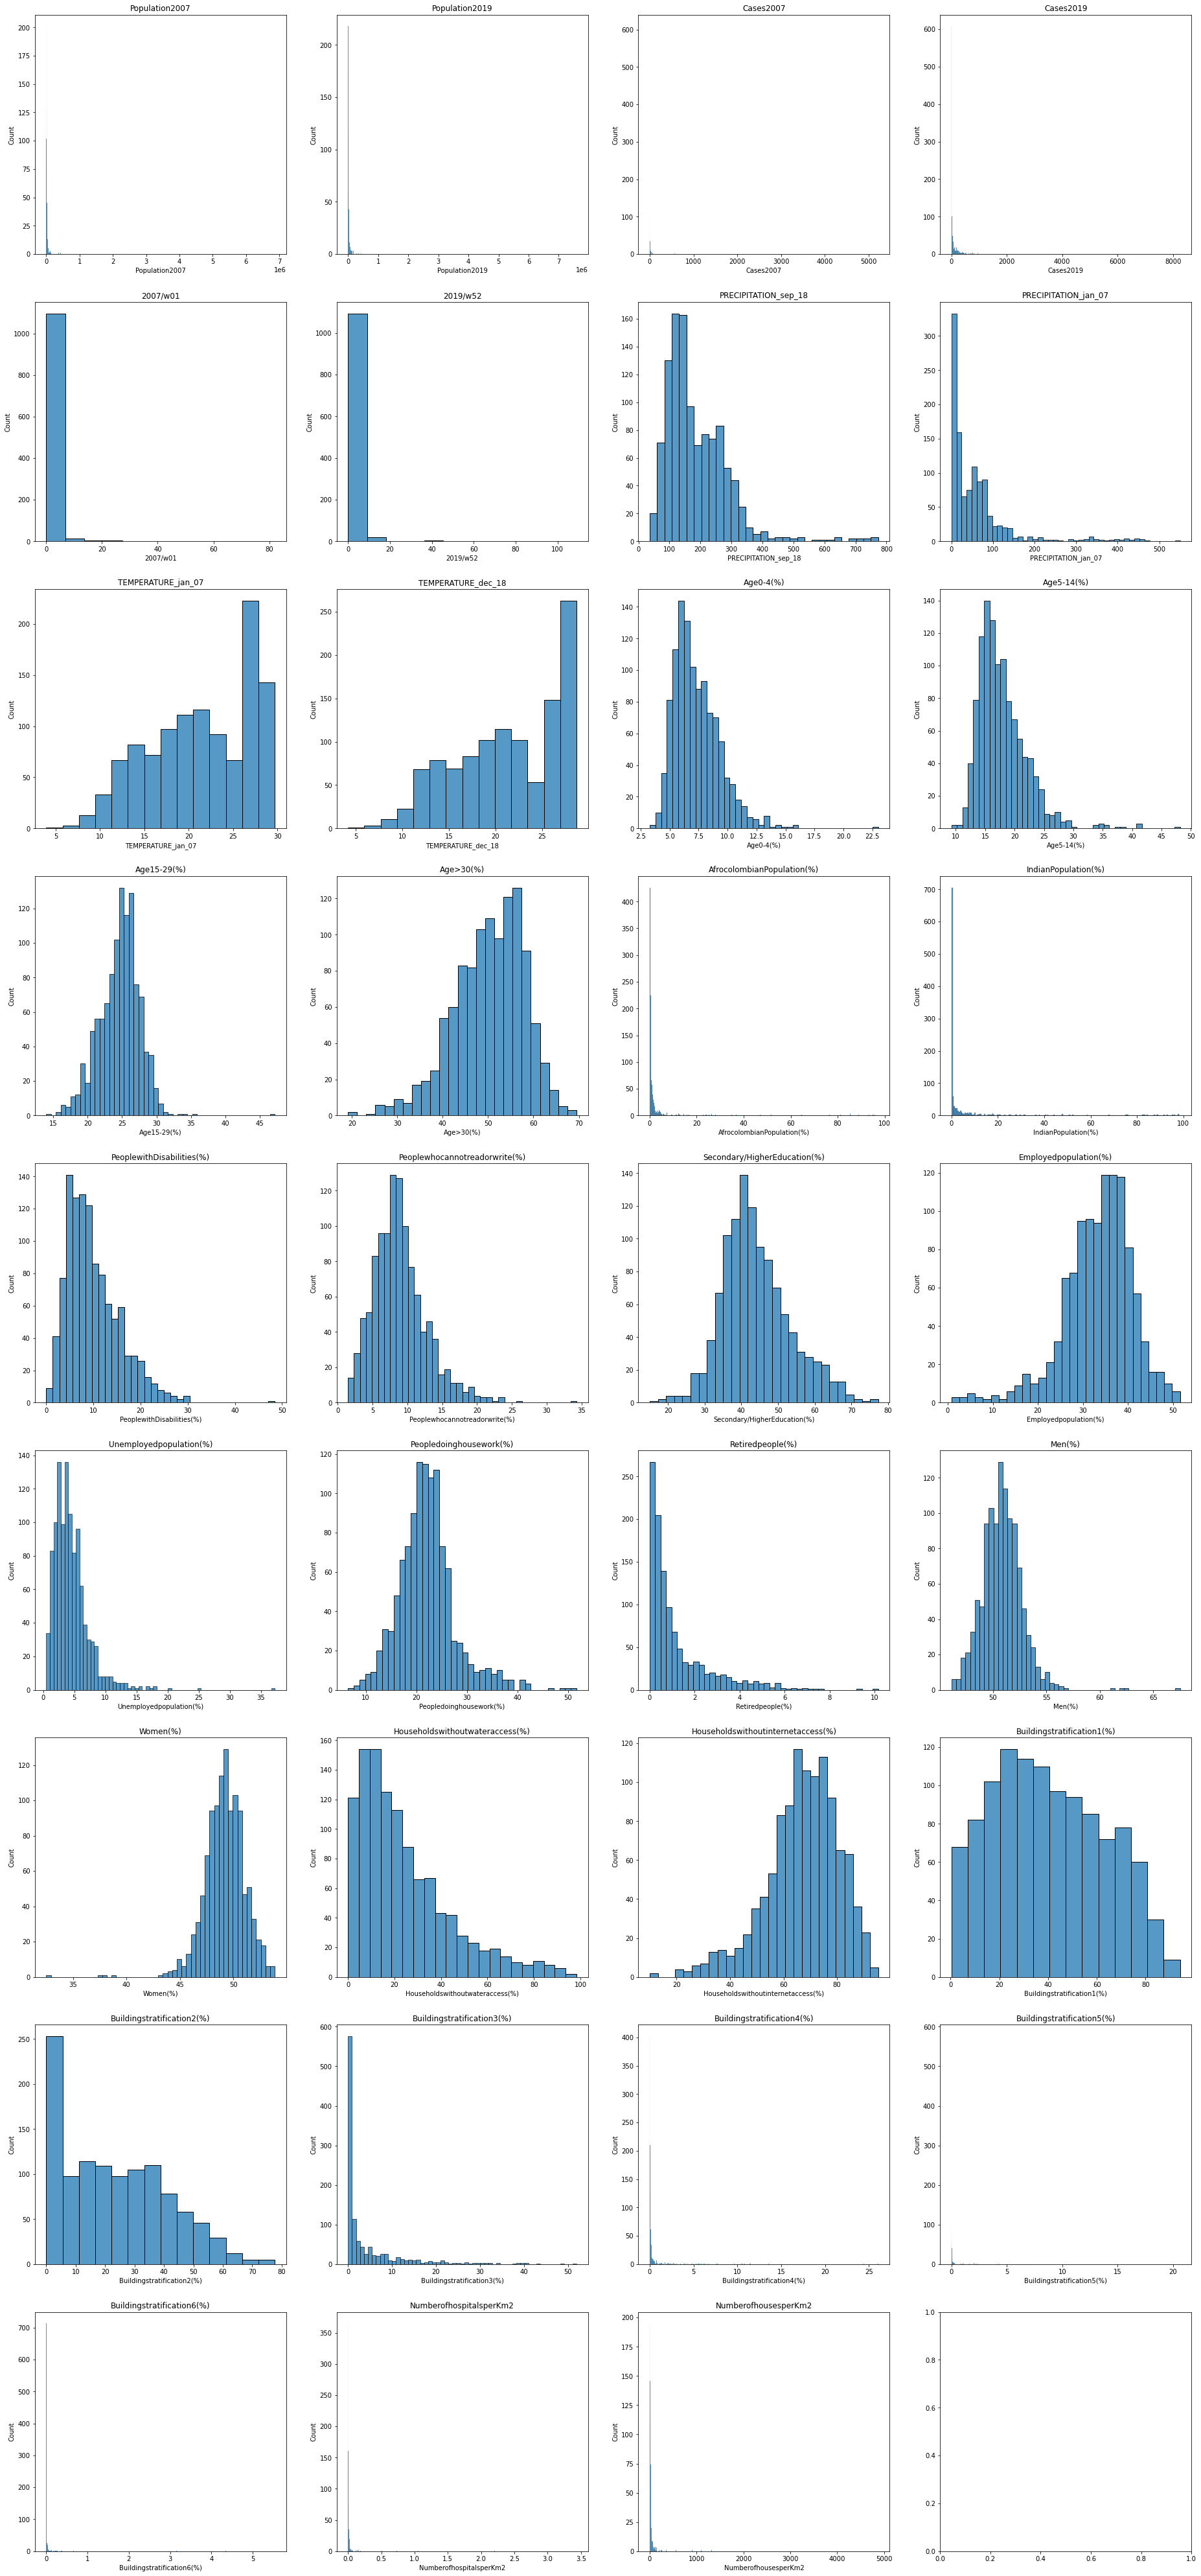

In [23]:
x = 9
y = 4

fig, ax = plt.subplots(x, y, figsize=(32, 72))
col = 0
column = data_df.columns
for i in range(x):
    for j in range(y):
        if col < len(column):
            sns.histplot(data_df[column[col]], ax=ax[i][j])
            ax[i][j].set_title(*[column[col]])
            col+=1

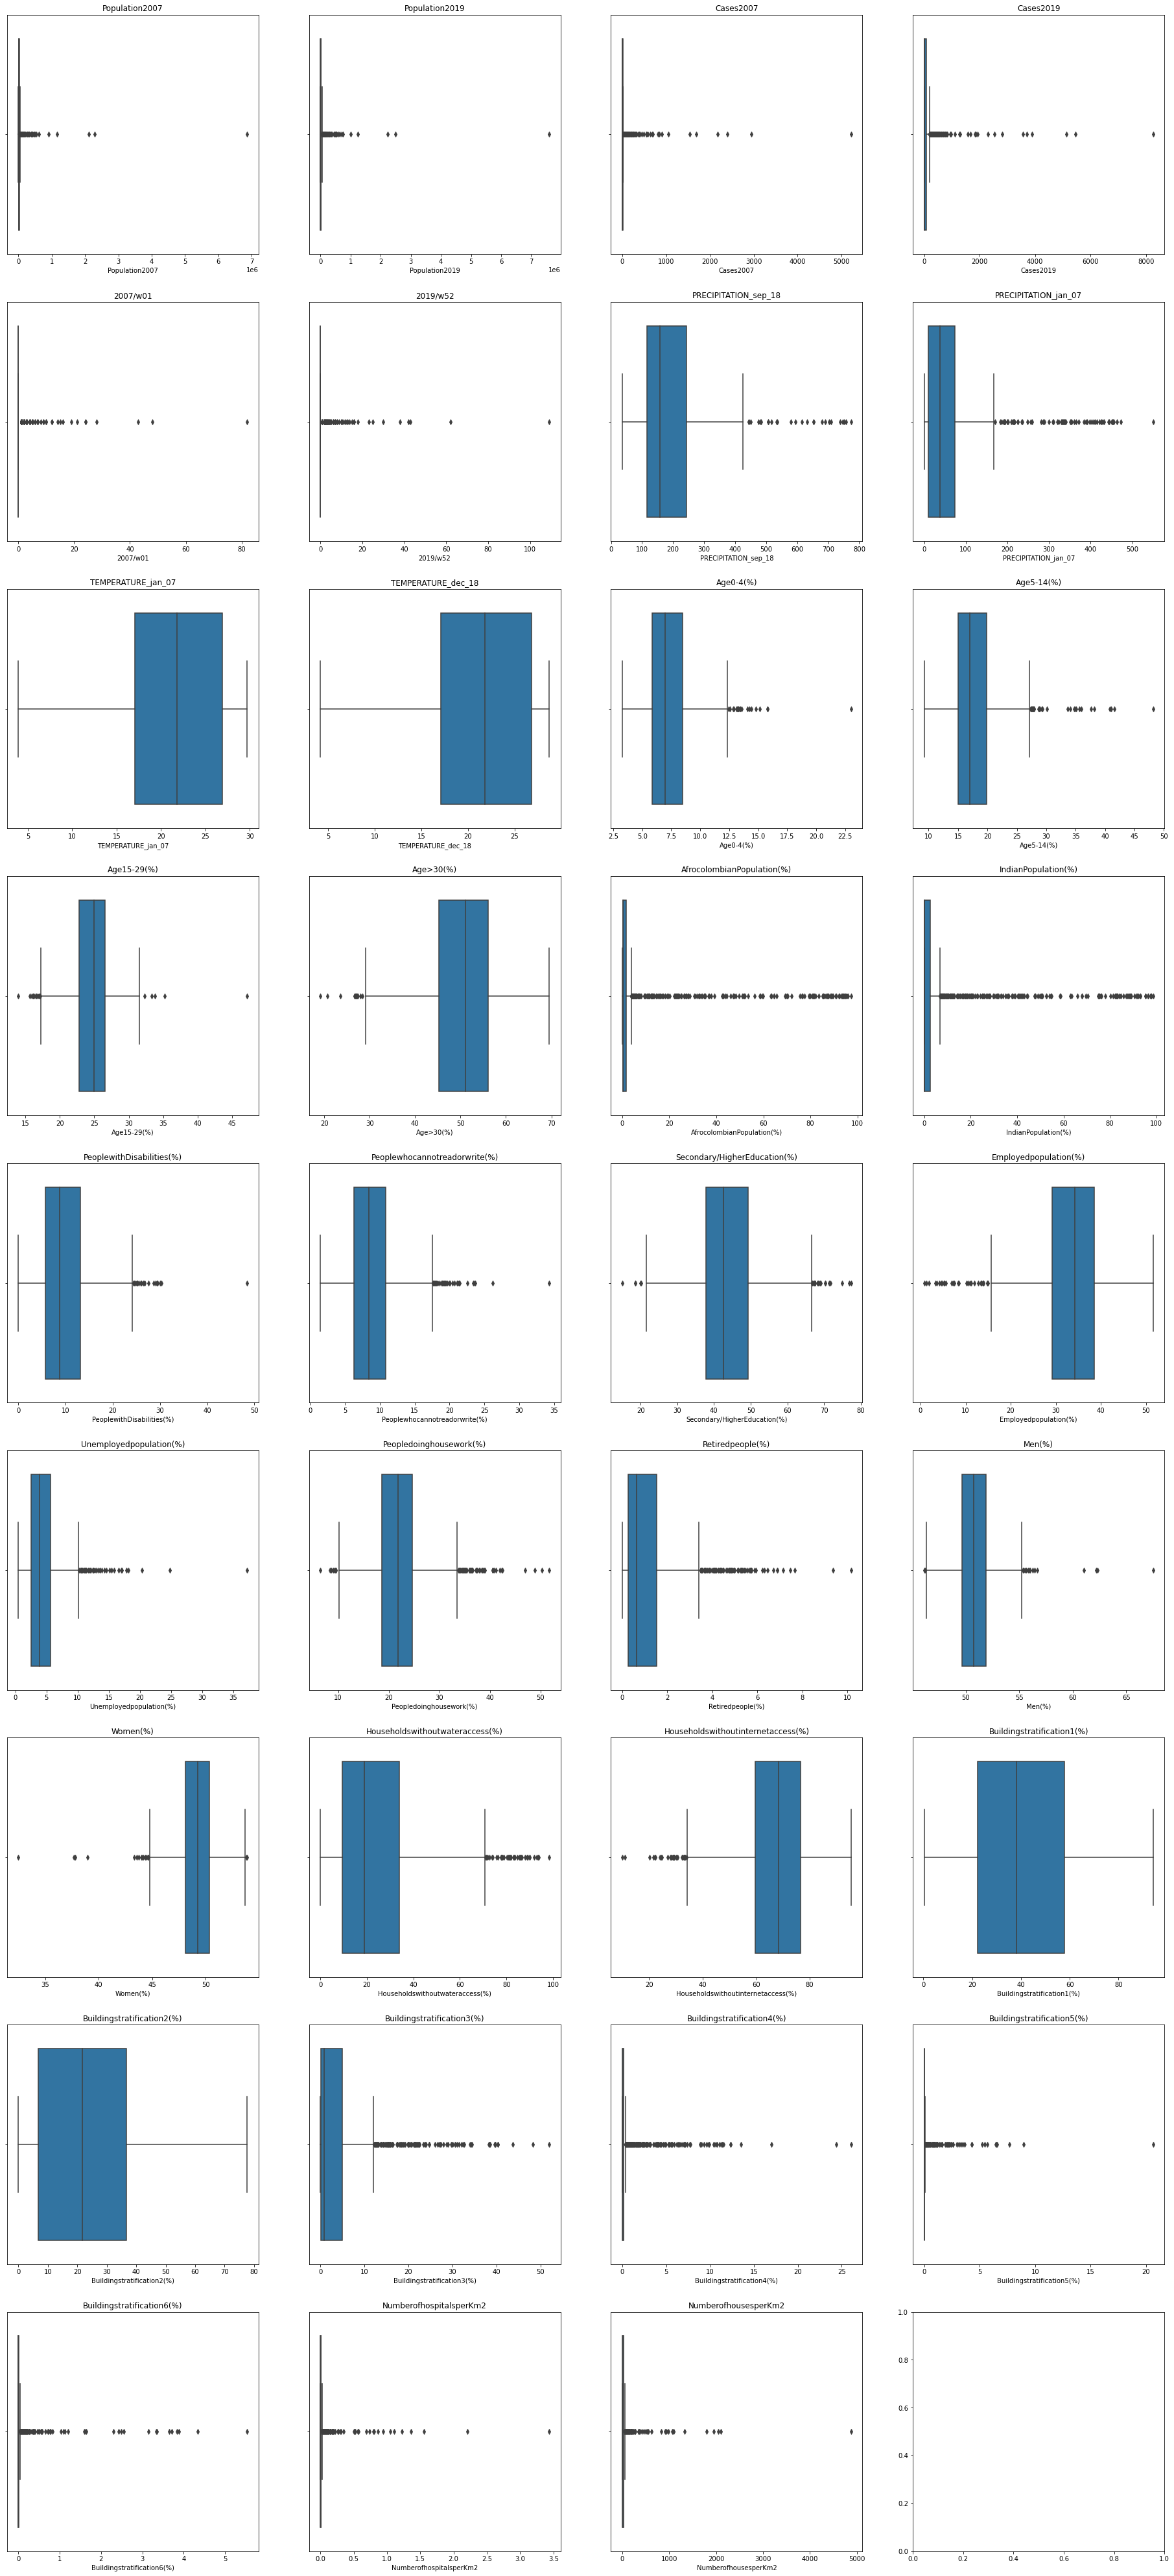

In [24]:
x = 9
y = 4

fig, ax = plt.subplots(x, y, figsize=(32, 72))
col = 0
column = data_df.columns
for i in range(x):
    for j in range(y):
        if col < len(column):
            sns.boxplot(data=data_df, x=column[col], ax=ax[i][j])
            ax[i][j].set_title(*[column[col]])
            col+=1

In [179]:
weeks_df = dengue_df[['2007/w01', '2007/w02', '2007/w03', '2007/w04', '2007/w05', '2007/w06', '2007/w07', '2007/w08', '2007/w09', '2007/w10', '2007/w11', '2007/w12', '2007/w13', '2007/w14', '2007/w15', '2007/w16', '2007/w17', '2007/w18', '2007/w19', '2007/w20', '2007/w21', '2007/w22', '2007/w23', '2007/w24', '2007/w25', '2007/w26', '2007/w27', '2007/w28', '2007/w29', '2007/w30', '2007/w31', '2007/w32', '2007/w33', '2007/w34', '2007/w35', '2007/w36', '2007/w37', '2007/w38', '2007/w39', '2007/w40', '2007/w41', '2007/w42', '2007/w43', '2007/w44', '2007/w45', '2007/w46', '2007/w47', '2007/w48', '2007/w49', '2007/w50', '2007/w51', '2007/w52', '2008/w01', '2008/w02', '2008/w03', '2008/w04', '2008/w05', '2008/w06', '2008/w07', '2008/w08', '2008/w09', '2008/w10', '2008/w11', '2008/w12', '2008/w13', '2008/w14', '2008/w15', '2008/w16', '2008/w17', '2008/w18', '2008/w19', '2008/w20', '2008/w21', '2008/w22', '2008/w23', '2008/w24', '2008/w25', '2008/w26', '2008/w27', '2008/w28', '2008/w29', '2008/w30', '2008/w31', '2008/w32', '2008/w33', '2008/w34', '2008/w35', '2008/w36', '2008/w37', '2008/w38', '2008/w39', '2008/w40', '2008/w41', '2008/w42', '2008/w43', '2008/w44', '2008/w45', '2008/w46', '2008/w47', '2008/w48', '2008/w49', '2008/w50', '2008/w51', '2008/w52', '2009/w01', '2009/w02', '2009/w03', '2009/w04', '2009/w05', '2009/w06', '2009/w07', '2009/w08', '2009/w09', '2009/w10', '2009/w11', '2009/w12', '2009/w13', '2009/w14', '2009/w15', '2009/w16', '2009/w17', '2009/w18', '2009/w19', '2009/w20', '2009/w21', '2009/w22', '2009/w23', '2009/w24', '2009/w25', '2009/w26', '2009/w27', '2009/w28', '2009/w29', '2009/w30', '2009/w31', '2009/w32', '2009/w33', '2009/w34', '2009/w35', '2009/w36', '2009/w37', '2009/w38', '2009/w39', '2009/w40', '2009/w41', '2009/w42', '2009/w43', '2009/w44', '2009/w45', '2009/w46', '2009/w47', '2009/w48', '2009/w49', '2009/w50', '2009/w51', '2009/w52', '2010/w01', '2010/w02', '2010/w03', '2010/w04', '2010/w05', '2010/w06', '2010/w07', '2010/w08', '2010/w09', '2010/w10', '2010/w11', '2010/w12', '2010/w13', '2010/w14', '2010/w15', '2010/w16', '2010/w17', '2010/w18', '2010/w19', '2010/w20', '2010/w21', '2010/w22', '2010/w23', '2010/w24', '2010/w25', '2010/w26', '2010/w27', '2010/w28', '2010/w29', '2010/w30', '2010/w31', '2010/w32', '2010/w33', '2010/w34', '2010/w35', '2010/w36', '2010/w37', '2010/w38', '2010/w39', '2010/w40', '2010/w41', '2010/w42', '2010/w43', '2010/w44', '2010/w45', '2010/w46', '2010/w47', '2010/w48', '2010/w49', '2010/w50', '2010/w51', '2010/w52', '2011/w01', '2011/w02', '2011/w03', '2011/w04', '2011/w05', '2011/w06', '2011/w07', '2011/w08', '2011/w09', '2011/w10', '2011/w11', '2011/w12', '2011/w13', '2011/w14', '2011/w15', '2011/w16', '2011/w17', '2011/w18', '2011/w19', '2011/w20', '2011/w21', '2011/w22', '2011/w23', '2011/w24', '2011/w25', '2011/w26', '2011/w27', '2011/w28', '2011/w29', '2011/w30', '2011/w31', '2011/w32', '2011/w33', '2011/w34', '2011/w35', '2011/w36', '2011/w37', '2011/w38', '2011/w39', '2011/w40', '2011/w41', '2011/w42', '2011/w43', '2011/w44', '2011/w45', '2011/w46', '2011/w47', '2011/w48', '2011/w49', '2011/w50', '2011/w51', '2011/w52', '2012/w01', '2012/w02', '2012/w03', '2012/w04', '2012/w05', '2012/w06', '2012/w07', '2012/w08', '2012/w09', '2012/w10', '2012/w11', '2012/w12', '2012/w13', '2012/w14', '2012/w15', '2012/w16', '2012/w17', '2012/w18', '2012/w19', '2012/w20', '2012/w21', '2012/w22', '2012/w23', '2012/w24', '2012/w25', '2012/w26', '2012/w27', '2012/w28', '2012/w29', '2012/w30', '2012/w31', '2012/w32', '2012/w33', '2012/w34', '2012/w35', '2012/w36', '2012/w37', '2012/w38', '2012/w39', '2012/w40', '2012/w41', '2012/w42', '2012/w43', '2012/w44', '2012/w45', '2012/w46', '2012/w47', '2012/w48', '2012/w49', '2012/w50', '2012/w51', '2012/w52', '2013/w01', '2013/w02', '2013/w03', '2013/w04', '2013/w05', '2013/w06', '2013/w07', '2013/w08', '2013/w09', '2013/w10', '2013/w11', '2013/w12', '2013/w13', '2013/w14', '2013/w15', '2013/w16', '2013/w17', '2013/w18', '2013/w19', '2013/w20', '2013/w21', '2013/w22', '2013/w23', '2013/w24', '2013/w25', '2013/w26', '2013/w27', '2013/w28', '2013/w29', '2013/w30', '2013/w31', '2013/w32', '2013/w33', '2013/w34', '2013/w35', '2013/w36', '2013/w37', '2013/w38', '2013/w39', '2013/w40', '2013/w41', '2013/w42', '2013/w43', '2013/w44', '2013/w45', '2013/w46', '2013/w47', '2013/w48', '2013/w49', '2013/w50', '2013/w51', '2013/w52', '2014/w01', '2014/w02', '2014/w03', '2014/w04', '2014/w05', '2014/w06', '2014/w07', '2014/w08', '2014/w09', '2014/w10', '2014/w11', '2014/w12', '2014/w13', '2014/w14', '2014/w15', '2014/w16', '2014/w17', '2014/w18', '2014/w19', '2014/w20', '2014/w21', '2014/w22', '2014/w23', '2014/w24', '2014/w25', '2014/w26', '2014/w27', '2014/w28', '2014/w29', '2014/w30', '2014/w31', '2014/w32', '2014/w33', '2014/w34', '2014/w35', '2014/w36', '2014/w37', '2014/w38', '2014/w39', '2014/w40', '2014/w41', '2014/w42', '2014/w43', '2014/w44', '2014/w45', '2014/w46', '2014/w47', '2014/w48', '2014/w49', '2014/w50', '2014/w51', '2014/w52', '2015/w01', '2015/w02', '2015/w03', '2015/w04', '2015/w05', '2015/w06', '2015/w07', '2015/w08', '2015/w09', '2015/w10', '2015/w11', '2015/w12', '2015/w13', '2015/w14', '2015/w15', '2015/w16', '2015/w17', '2015/w18', '2015/w19', '2015/w20', '2015/w21', '2015/w22', '2015/w23', '2015/w24', '2015/w25', '2015/w26', '2015/w27', '2015/w28', '2015/w29', '2015/w30', '2015/w31', '2015/w32', '2015/w33', '2015/w34', '2015/w35', '2015/w36', '2015/w37', '2015/w38', '2015/w39', '2015/w40', '2015/w41', '2015/w42', '2015/w43', '2015/w44', '2015/w45', '2015/w46', '2015/w47', '2015/w48', '2015/w49', '2015/w50', '2015/w51', '2015/w52', '2016/w01', '2016/w02', '2016/w03', '2016/w04', '2016/w05', '2016/w06', '2016/w07', '2016/w08', '2016/w09', '2016/w10', '2016/w11', '2016/w12', '2016/w13', '2016/w14', '2016/w15', '2016/w16', '2016/w17', '2016/w18', '2016/w19', '2016/w20', '2016/w21', '2016/w22', '2016/w23', '2016/w24', '2016/w25', '2016/w26', '2016/w27', '2016/w28', '2016/w29', '2016/w30', '2016/w31', '2016/w32', '2016/w33', '2016/w34', '2016/w35', '2016/w36', '2016/w37', '2016/w38', '2016/w39', '2016/w40', '2016/w41', '2016/w42', '2016/w43', '2016/w44', '2016/w45', '2016/w46', '2016/w47', '2016/w48', '2016/w49', '2016/w50', '2016/w51', '2016/w52', '2017/w01', '2017/w02', '2017/w03', '2017/w04', '2017/w05', '2017/w06', '2017/w07', '2017/w08', '2017/w09', '2017/w10', '2017/w11', '2017/w12', '2017/w13', '2017/w14', '2017/w15', '2017/w16', '2017/w17', '2017/w18', '2017/w19', '2017/w20', '2017/w21', '2017/w22', '2017/w23', '2017/w24', '2017/w25', '2017/w26', '2017/w27', '2017/w28', '2017/w29', '2017/w30', '2017/w31', '2017/w32', '2017/w33', '2017/w34', '2017/w35', '2017/w36', '2017/w37', '2017/w38', '2017/w39', '2017/w40', '2017/w41', '2017/w42', '2017/w43', '2017/w44', '2017/w45', '2017/w46', '2017/w47', '2017/w48', '2017/w49', '2017/w50', '2017/w51', '2017/w52', '2018/w01', '2018/w02', '2018/w03', '2018/w04', '2018/w05', '2018/w06', '2018/w07', '2018/w08', '2018/w09', '2018/w10', '2018/w11', '2018/w12', '2018/w13', '2018/w14', '2018/w15', '2018/w16', '2018/w17', '2018/w18', '2018/w19', '2018/w20', '2018/w21', '2018/w22', '2018/w23', '2018/w24', '2018/w25', '2018/w26', '2018/w27', '2018/w28', '2018/w29', '2018/w30', '2018/w31', '2018/w32', '2018/w33', '2018/w34', '2018/w35', '2018/w36', '2018/w37', '2018/w38', '2018/w39', '2018/w40', '2018/w41', '2018/w42', '2018/w43', '2018/w44', '2018/w45', '2018/w46', '2018/w47', '2018/w48', '2018/w49', '2018/w50', '2018/w51', '2018/w52', '2019/w01', '2019/w02', '2019/w03', '2019/w04', '2019/w05', '2019/w06', '2019/w07', '2019/w08', '2019/w09', '2019/w10', '2019/w11', '2019/w12', '2019/w13', '2019/w14', '2019/w15', '2019/w16', '2019/w17', '2019/w18', '2019/w19', '2019/w20', '2019/w21', '2019/w22', '2019/w23', '2019/w24', '2019/w25', '2019/w26', '2019/w27', '2019/w28', '2019/w29', '2019/w30', '2019/w31', '2019/w32', '2019/w33', '2019/w34', '2019/w35', '2019/w36', '2019/w37', '2019/w38', '2019/w39', '2019/w40', '2019/w41', '2019/w42', '2019/w43', '2019/w44', '2019/w45', '2019/w46', '2019/w47', '2019/w48', '2019/w49', '2019/w50', '2019/w51', '2019/w52']]
population_df = dengue_df[['Population2007', 'Population2008', 'Population2009', 'Population2010', 'Population2011', 'Population2012', 'Population2013', 'Population2014', 'Population2015', 'Population2016', 'Population2017', 'Population2018', 'Population2019']]
casos_df = dengue_df[['Cases2007', 'Cases2008', 'Cases2009', 'Cases2010', 'Cases2011', 'Cases2012', 'Cases2013', 'Cases2014', 'Cases2015', 'Cases2016', 'Cases2017', 'Cases2018', 'Cases2019']]
demo_df = dengue_df[['Age0-4(%)', 'Age5-14(%)', 'Age15-29(%)', 'Age>30(%)', 'AfrocolombianPopulation(%)', 'IndianPopulation(%)', 'PeoplewithDisabilities(%)', 'Peoplewhocannotreadorwrite(%)', 'Secondary/HigherEducation(%)', 'Employedpopulation(%)', 'Unemployedpopulation(%)', 'Peopledoinghousework(%)', 'Retiredpeople(%)', 'Men(%)', 'Women(%)', 'Householdswithoutwateraccess(%)', 'Householdswithoutinternetaccess(%)', 'Buildingstratification1(%)', 'Buildingstratification2(%)', 'Buildingstratification3(%)', 'Buildingstratification4(%)', 'Buildingstratification5(%)', 'Buildingstratification6(%)', 'NumberofhospitalsperKm2', 'NumberofhousesperKm2']]


X_df = dengue_df.drop(columns=['Municipality', 'Municipality code'])
target_df = dengue_df[['Municipality', 'Municipality code']]


In [180]:
target_df = dengue_df[['Municipality', 'Municipality code']]
target_df['Casos_total'] = casos_df.sum(axis=1).values

C:\Users\User\AppData\Local\Temp\ipykernel_17080\2999092150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Casos_total'] = casos_df.sum(axis=1).values


In [185]:
dengue_df[['Municipality code', 'Municipality', 'Cases2009']].sort_values(by=['Cases2009'], ascending=False).head(20)

,Municipality code,Municipality,Cases2009
1005,76001,Cali,6335
845,68001,Bucaramanga,3449
779,54001,Cúcuta,3105
604,41001,Neiva,2248
877,68276,Floridablanca,2236
1031,76520,Palmira,2060
958,73001,Ibagué,1828
1054,85001,Yopal,1756
686,50001,Villavicencio,1711
125,8001,Barranquilla,1416


In [186]:
dengue_df[['Municipality code', 'Municipality', 'Cases2019']].sort_values(by=['Cases2019'], ascending=False).head(20)

,Municipality code,Municipality,Cases2019
686,50001,Villavicencio,8258
604,41001,Neiva,5459
958,73001,Ibagué,5130
1005,76001,Cali,3890
932,70001,Sincelejo,3693
779,54001,Cúcuta,3569
403,20001,Valledupar,2817
845,68001,Bucaramanga,2525
1054,85001,Yopal,2291
149,13001,Cartagena de Indias,1922


In [188]:
target_df.sort_values(by=['Casos_total'], ascending=False).head(50)

,Municipality,Municipality code,Casos_total
1005,Cali,76001,89515
0,Medellín,5001,49547
845,Bucaramanga,68001,38818
779,Cúcuta,54001,38170
958,Ibagué,73001,35749
686,Villavicencio,50001,35726
604,Neiva,41001,27190
125,Barranquilla,8001,23931
877,Floridablanca,68276,21399
932,Sincelejo,70001,15874


In [189]:
casos_df.sum(axis=1).describe()

count     1120.000000
mean       882.341964
std       4176.447185
min          0.000000
25%         17.000000
50%        132.500000
75%        487.000000
max      89515.000000
dtype: float64

In [217]:
top_casos_df = target_df[casos_df.sum(axis=1) >= casos_df.sum(axis=1).quantile(.95)].sort_values(by=['Casos_total'], ascending=False)
top_casos_df

,Municipality,Municipality code,Casos_total
1005,Cali,76001,89515
0,Medellín,5001,49547
845,Bucaramanga,68001,38818
779,Cúcuta,54001,38170
958,Ibagué,73001,35749
686,Villavicencio,50001,35726
604,Neiva,41001,27190
125,Barranquilla,8001,23931
877,Floridablanca,68276,21399
932,Sincelejo,70001,15874


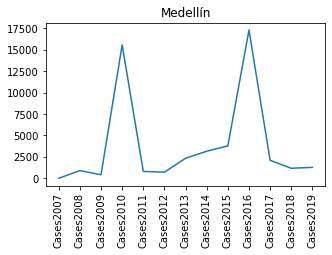

In [226]:
def get_evolution_casos(code=5001, municipio="Medellín"):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ax.plot(dengue_df[(dengue_df['Municipality code']==code) & (dengue_df['Municipality']==municipio)].filter(regex=("Cases20.*")).sum(axis=0))
    _ = ax.set_xticklabels(labels=['Cases2007', 'Cases2008', 'Cases2009', 'Cases2010', 'Cases2011', 'Cases2012', 'Cases2013', 'Cases2014', 'Cases2015', 'Cases2016', 'Cases2017', 'Cases2018', 'Cases2019'], rotation=90)
    _ = ax.set_title(municipio)
    
get_evolution_casos()

Text(0.5, 1.0, 'Evolucion de casos Colombia')

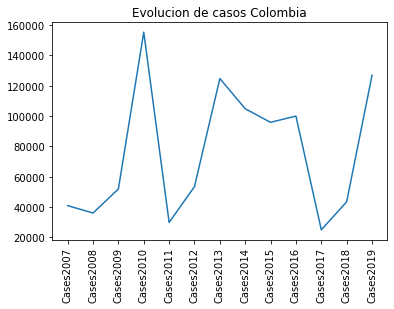

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(casos_df.sum(axis=0))
_ = ax.set_xticklabels(labels=['Cases2007', 'Cases2008', 'Cases2009', 'Cases2010', 'Cases2011', 'Cases2012', 'Cases2013', 'Cases2014', 'Cases2015', 'Cases2016', 'Cases2017', 'Cases2018', 'Cases2019'], rotation=90)
ax.set_title("Evolucion de casos Colombia")

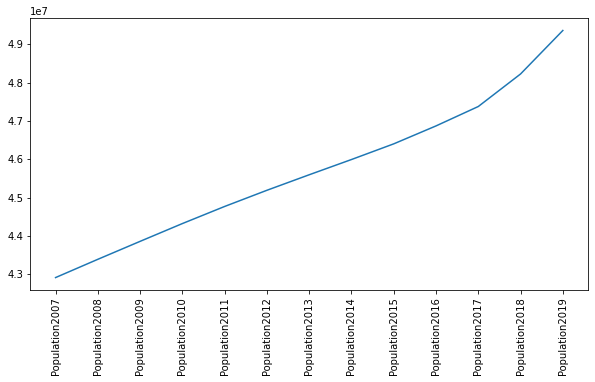

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(population_df.sum(axis=0))
_ = ax.set_xticklabels(labels=['Population2007', 'Population2008', 'Population2009', 'Population2010', 'Population2011', 'Population2012', 'Population2013', 'Population2014', 'Population2015', 'Population2016', 'Population2017', 'Population2018', 'Population2019'], rotation=90)

C:\Users\User\AppData\Local\Temp\ipykernel_17080\2090782095.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 3))


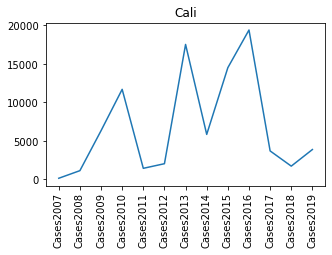

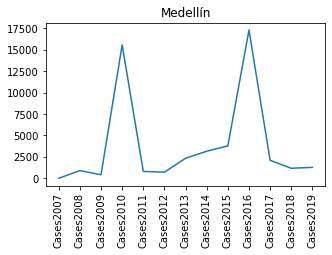

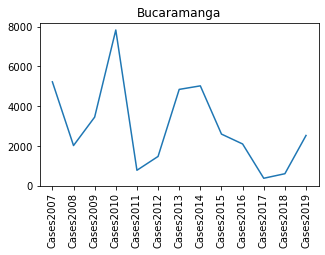

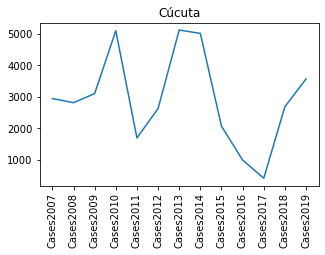

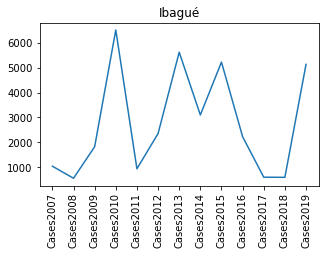

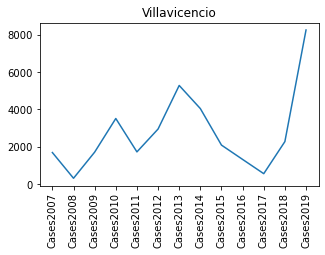

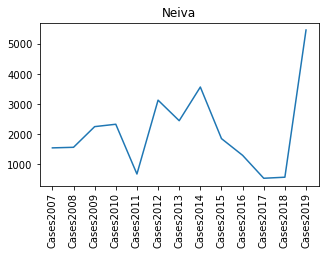

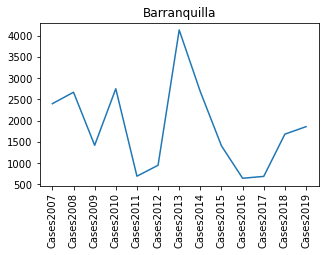

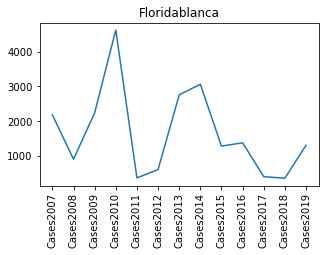

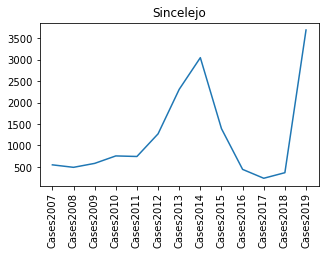

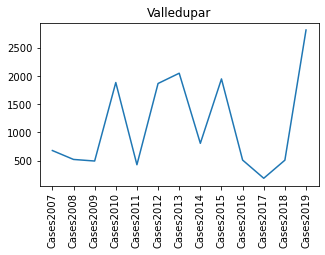

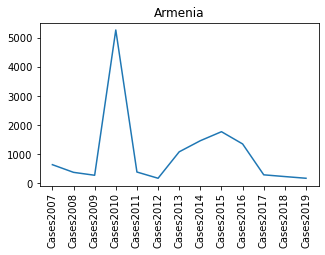

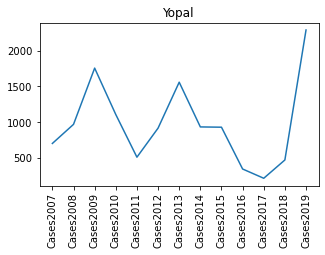

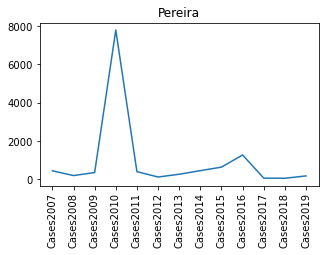

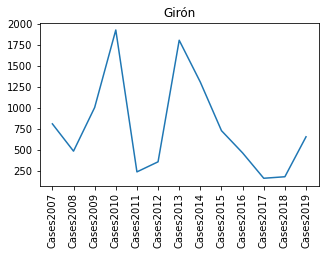

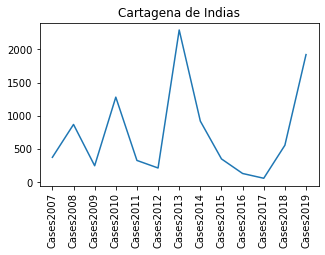

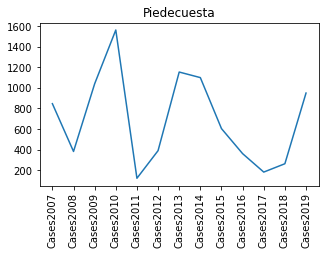

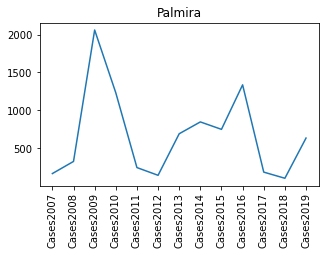

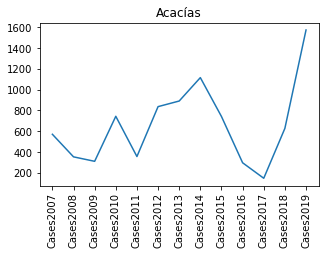

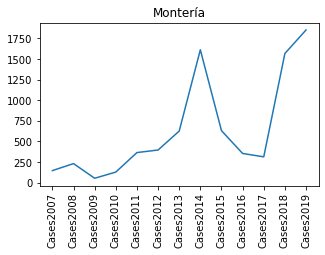

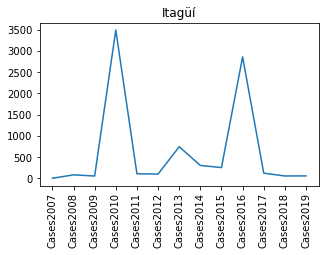

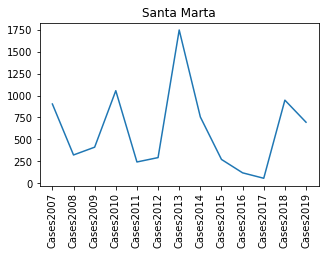

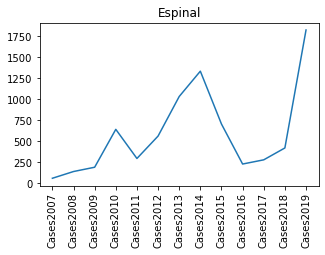

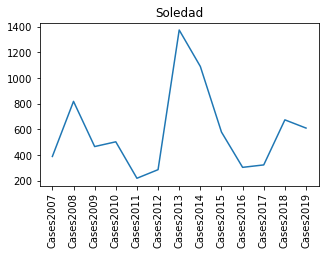

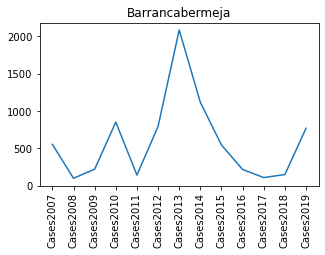

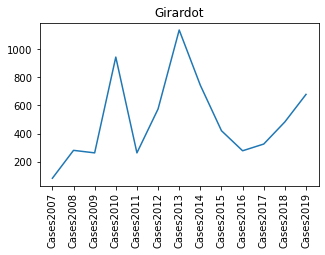

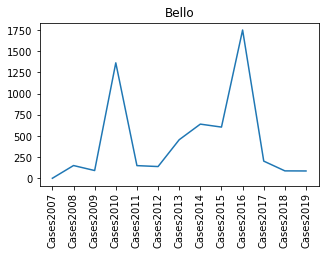

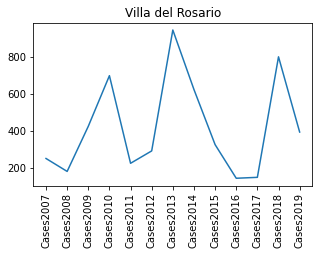

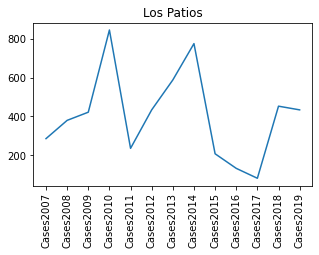

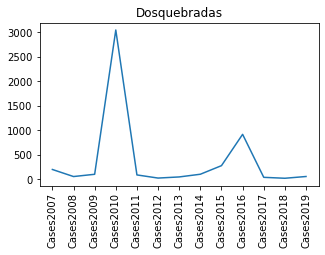

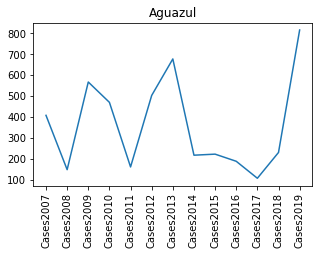

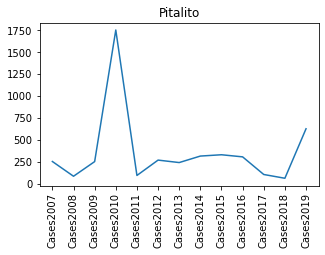

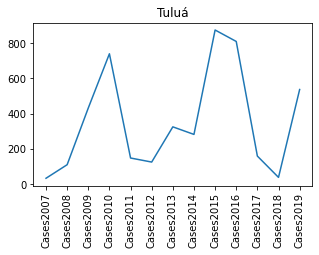

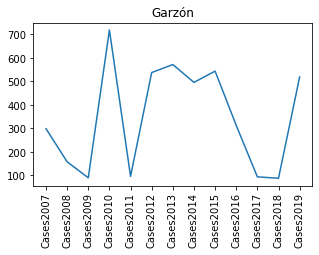

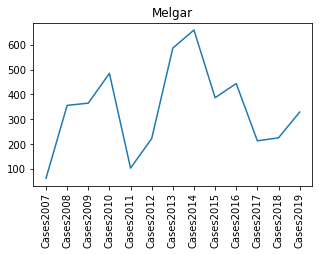

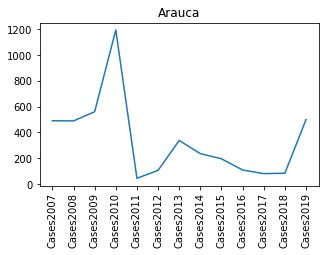

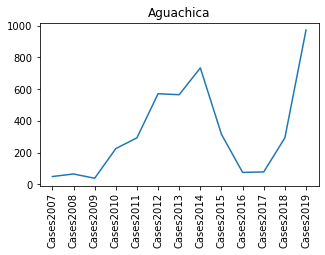

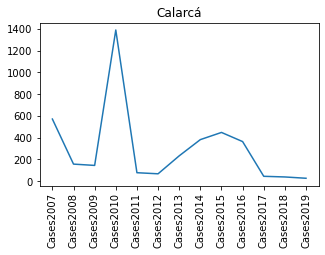

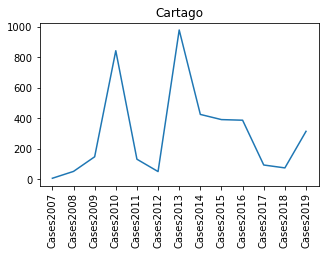

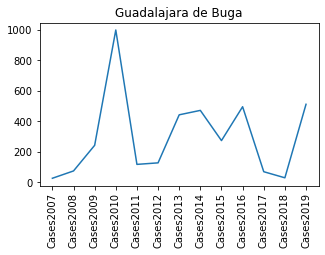

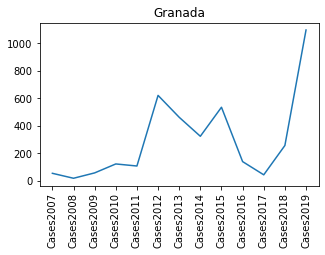

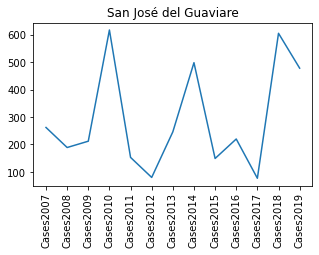

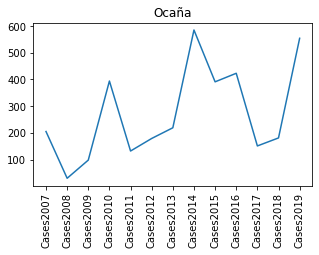

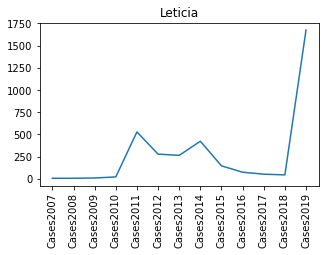

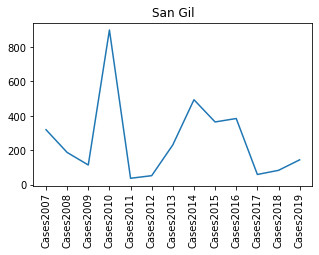

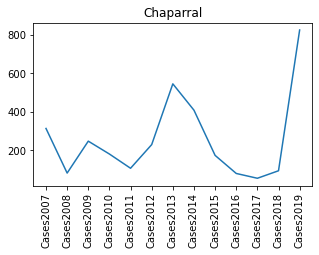

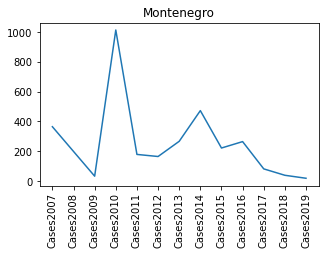

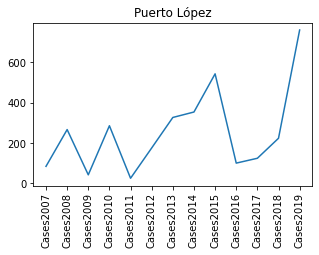

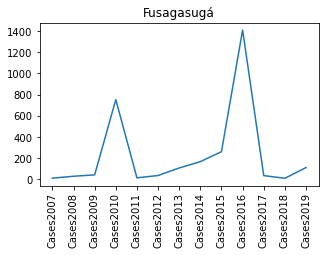

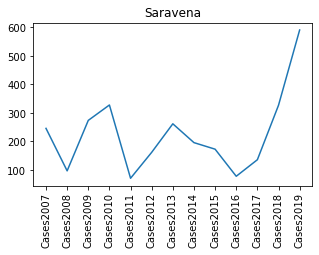

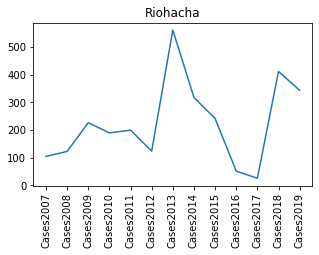

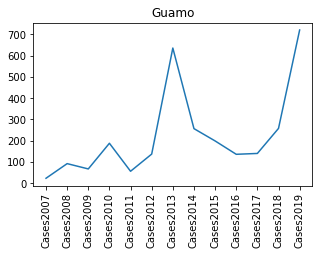

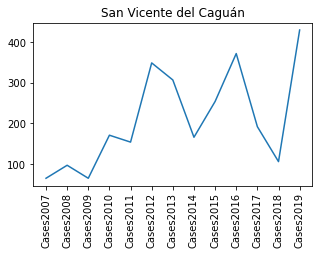

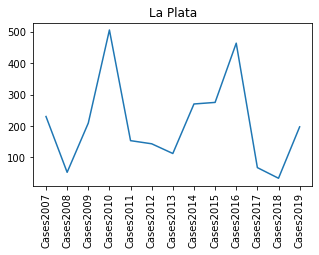

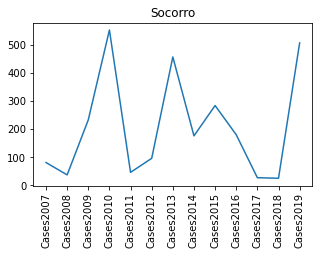

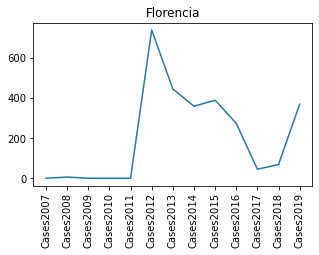

In [230]:
for i, row in top_casos_df.iterrows():
    get_evolution_casos(code=row['Municipality code'], municipio=row['Municipality'])

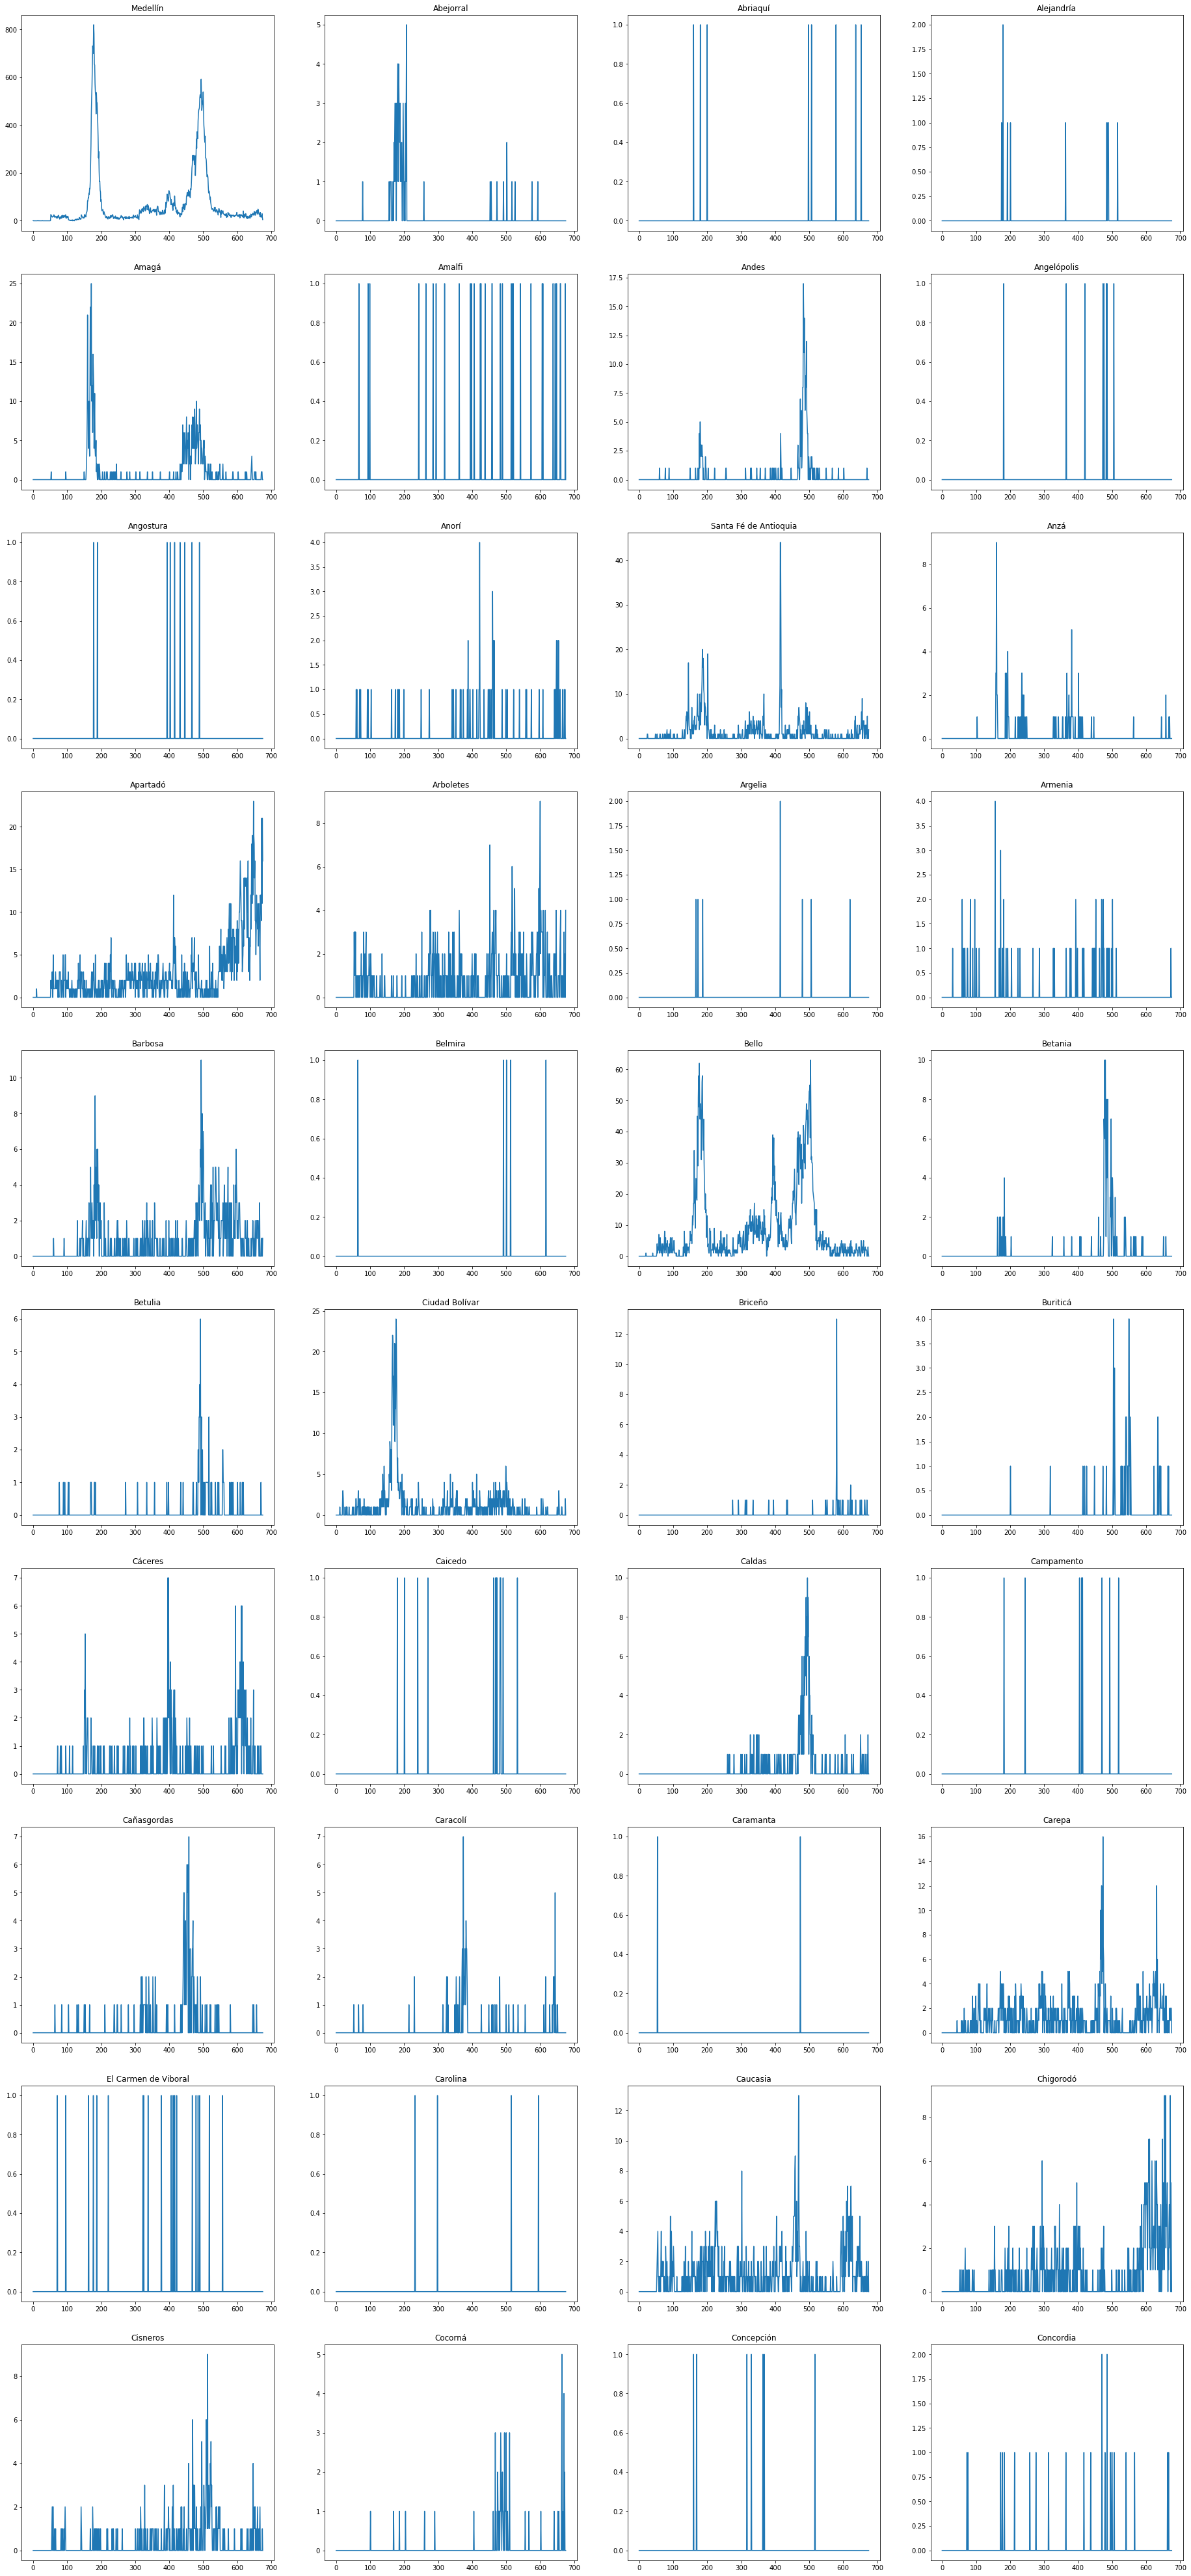

In [159]:
x = 10
y = 4

fig, ax = plt.subplots(x, y, figsize=(32, 72))
index = 0
rows = weeks_df.index
for i in range(x):
    for j in range(y):
        ax[i][j].plot(range(len(weeks_df.columns)), weeks_df.iloc[index, :].values)
        ax[i][j].set_title(*[dengue_df['Municipality'][index]])
        index+=1

Text(0.5, 1.0, 'Medellín')

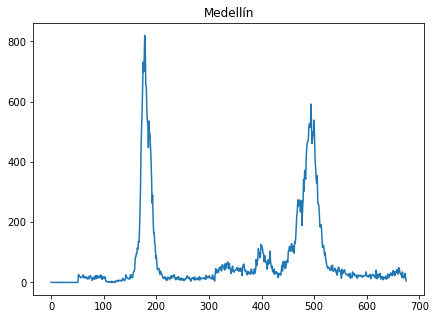

In [167]:
index = 0
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(range(len(weeks_df.columns)), weeks_df.iloc[index, :].values)
ax.set_title(*[dengue_df['Municipality'][index]])

<AxesSubplot:>

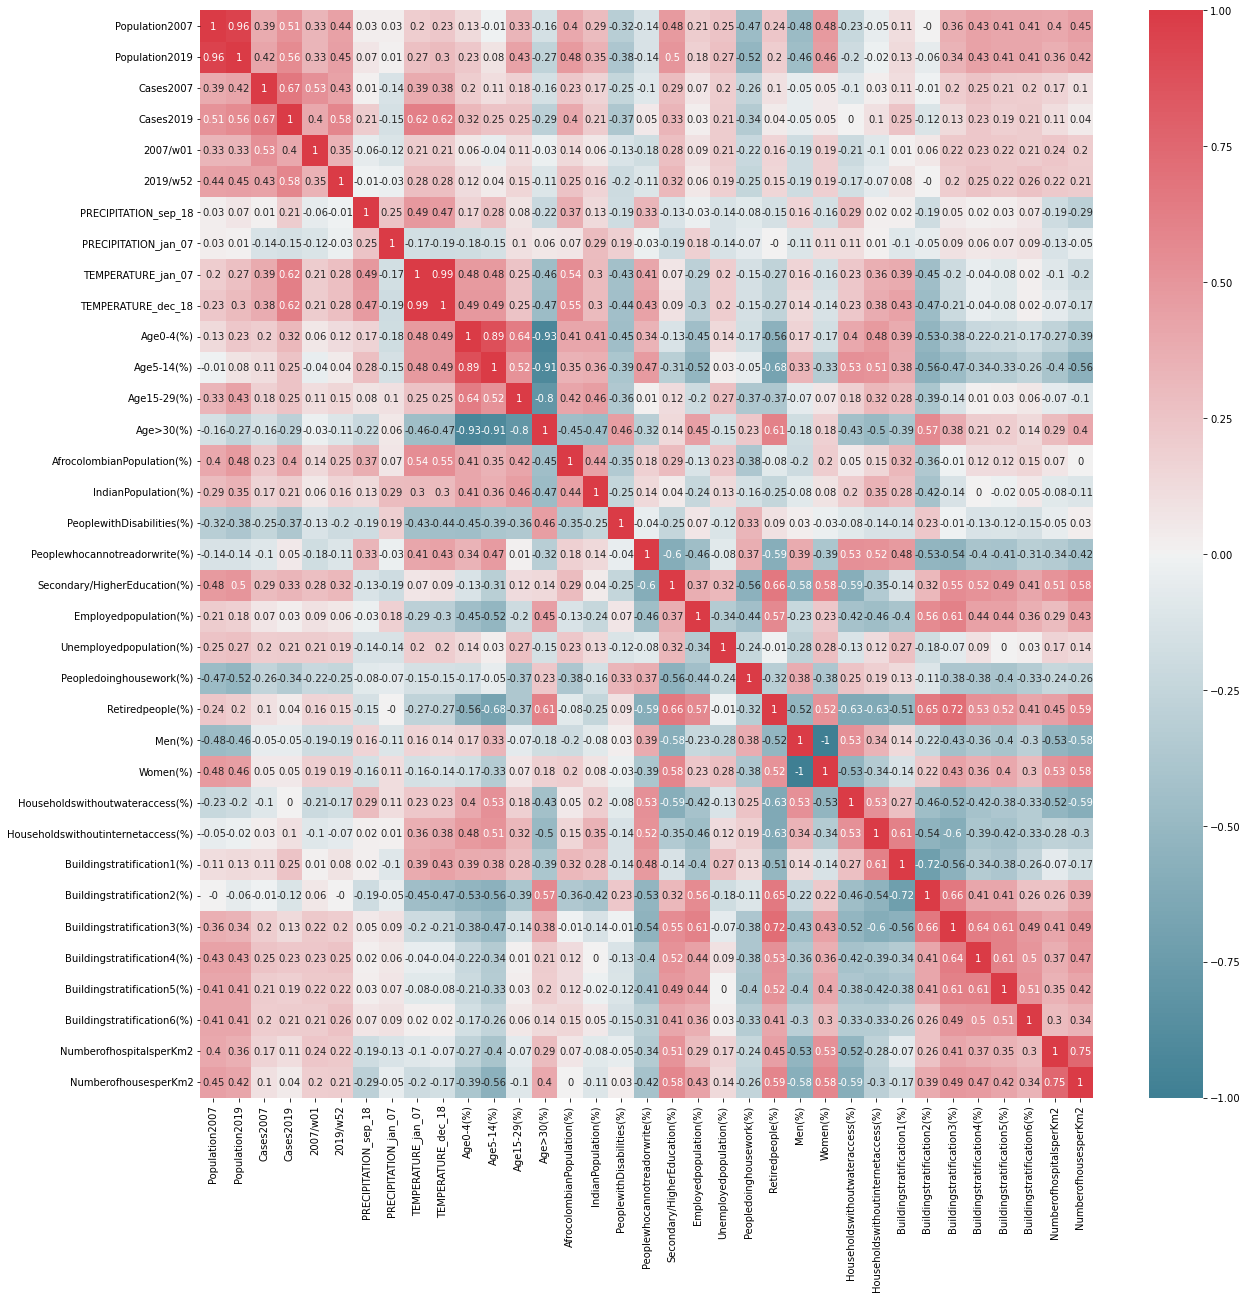

In [27]:
correlation_matrix = data_df.corr(method='spearman').round(2)
fig,axes = plt.subplots(1,1,figsize=(20,20))
sns.heatmap(data=correlation_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True,ax=axes)

In [235]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_df)

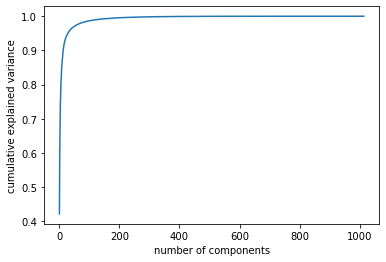

In [236]:
pca = PCA().fit(X_scale)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [237]:
pca_variance = PCA(n_components=0.98, svd_solver='full')
Z = pca_variance.fit_transform(X_scale)

print('# componentes: {}, varianza explicada:  {}\n'.format(len(pca_variance.components_), 
                                                       pca_variance.explained_variance_ratio_.sum()))

# componentes: 73, varianza explicada:  0.9802475960232022



In [238]:
Z.shape

(1120, 73)

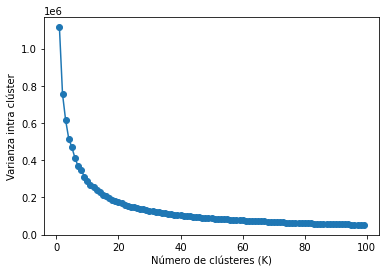

Coeficiente de Silhouette: maximo K= 2


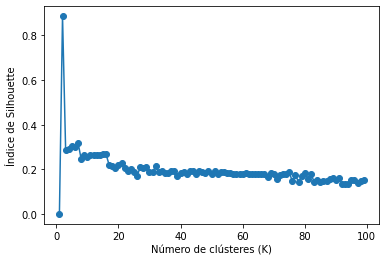

In [36]:
# Kmeans
varianza_intra_cluster = []
silhouettes = []

for i in range (1, 100): # Evaluamos entre 1 a 100 clusters posibles
    kmeans = KMeans(n_clusters = i, random_state = 123).fit(Z)
    varianza_intra_cluster.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(Z, kmeans.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)
    

plt.plot(range (1, 100), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

print("Coeficiente de Silhouette: maximo K= {}".format(np.array(silhouettes).argmax() + 1))
plt.plot(range (1, 100), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.show()

Done in 0.037s


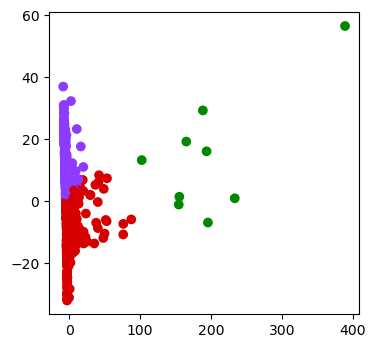

In [253]:
# kmeans
t0 = time()
kmeans = KMeans(n_clusters = 3, n_init=10, max_iter=300, random_state = 101).fit(Z)
print("Done in %0.3fs" % (time() - t0))
y_kmeans_pred = kmeans.predict(Z)

#plot
palette = sns.color_palette(cc.glasbey, n_colors=40)
color = [palette[k] for k in y_kmeans_pred]

fig, ax = plt.subplots(figsize = (4, 4), dpi = 100)
ax.scatter(Z[:, 0], Z[:, 1], c = color)

In [254]:
pd.DataFrame(y_kmeans_pred, index=X_df.index).value_counts()

0    622
1    489
2      9
dtype: int64

In [302]:
result_df = X_df.copy()
result_df['y_pred'] = y_kmeans_pred

target_df[result_df['y_pred'] == 2].sort_values(by=['Casos_total'], ascending=False)

,Municipality,Municipality code,Casos_total
1005,Cali,76001,89515
0,Medellín,5001,49547
845,Bucaramanga,68001,38818
779,Cúcuta,54001,38170
958,Ibagué,73001,35749
686,Villavicencio,50001,35726
604,Neiva,41001,27190
125,Barranquilla,8001,23931
877,Floridablanca,68276,21399


In [259]:
target_df[result_df['y_pred'] == 2].sort_values(by=['Casos_total'], ascending=False)

,Municipality,Municipality code,Casos_total
1005,Cali,76001,89515
0,Medellín,5001,49547
845,Bucaramanga,68001,38818
779,Cúcuta,54001,38170
958,Ibagué,73001,35749
686,Villavicencio,50001,35726
604,Neiva,41001,27190
125,Barranquilla,8001,23931
877,Floridablanca,68276,21399


11.154650963849528


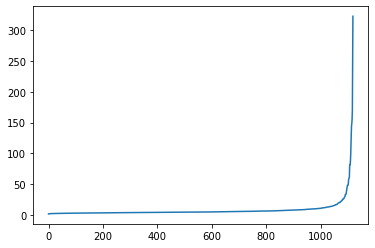

In [311]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(Z)
distances, indices = neighbors_fit.kneighbors(Z)


distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

print(distances[knee.knee])

In [294]:
# Utilice este espacio para escribir el código.
db = DBSCAN(eps=11.1546 , min_samples=2*Z.shape[1])
clusters=db.fit_predict(Z)

clusteres = db.labels_
n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
resultado = pd.DataFrame(Z).assign(Cluster = clusteres)

In [295]:
pd.DataFrame(clusteres).value_counts()

 0    662
-1    458
dtype: int64

In [312]:
result_df = X_df.copy()
result_df['y_pred'] = clusteres

target_df[result_df['y_pred'] == -1].sort_values(by=['Casos_total'], ascending=False)

,Municipality,Municipality code,Casos_total
1005,Cali,76001,89515
0,Medellín,5001,49547
845,Bucaramanga,68001,38818
779,Cúcuta,54001,38170
958,Ibagué,73001,35749
...,...,...,...
237,Güicán de La Sierra,15332,0
1094,Puerto Alegría,91530,0
1115,Papunahua,97777,0
1093,Mirití - Paraná,91460,0


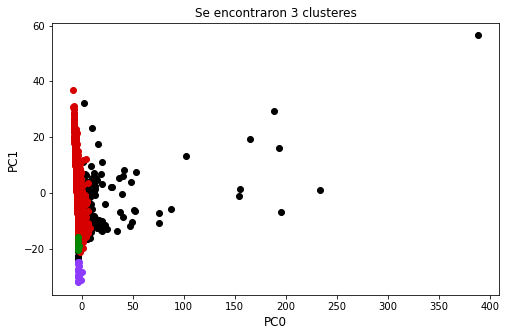

In [293]:
palette = sns.color_palette(cc.glasbey, n_colors=40)

fig, ax = plt.subplots(figsize=(8, 5))
for k in np.unique(clusteres):
    if k != -1:
        ax.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1], c = [palette[k]]
            )
    else:
        ax.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1],
            c = "black"
            )
    ax.set_title('Se encontraron %d clusteres' % (n_clusteres))

_ = ax.set_xlabel('PC0', fontsize=12)
_ = ax.set_ylabel('PC1', fontsize=12)